# Log
## Environment knowledge
### March
#### 4
* Point-goal nav: open3d library requires Python 3.10/11 (as of now)

#### 7
* Tried open3D point-cloud to occupancy grid.
* Considering generating graph using ground truth reachable positions and following shortest path to source.

# Sim

## iThor

In [1]:
!python -V

Python 3.10.16


In [2]:
# Check conda version
!conda -V

conda 24.9.2


In [3]:
# Check cuda version
!nvidia-smi

Wed Mar  5 12:39:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   38C    P8              1W /   90W |       6MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install --upgrade numpy scipy

In [ ]:
!pip3 install open3d

In [ ]:
# Install matplotlib
%conda install -c conda-forge matplotlib -y

# Install torch
!pip3 install torch torchvision torchaudio

# Install transformers
!pip install 'transformers[torch]'


%pip install ultralytics

%pip install ai2thor

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt

import cv2
from PIL import Image
import requests

import time
from ultralytics import YOLO
import torch

from transformers import CLIPProcessor, CLIPModel

from ai2thor.controller import Controller

### Initiate scene

In [5]:
controller = Controller(

    agentMode="default",
    visibilityDistance=1.5,

    scene="FloorPlan1",
    # scene="FloorPlan3",
    # kitchens = [f"FloorPlan{i}" for i in range(1, 31)]
    # living_rooms = [f"FloorPlan{200 + i}" for i in range(1, 31)]
    # bedrooms = [f"FloorPlan{300 + i}" for i in range(1, 31)]
    # bathrooms = [f"FloorPlan{400 + i}" for i in range(1, 31)]

    # step sizes
    gridSize=0.25,
    snapToGrid=True,
    rotateStepDegrees=90,

    # image modalities
    renderDepthImage=True,
    renderInstanceSegmentation=True,

    # camera properties
    width=300,
    height=300,
    fieldOfView=90
)

# controller.ithor_scenes(
#     include_kitchens=True,
#     include_living_rooms=True,
#     include_bedrooms=False,
#     include_bathrooms=False
# )


### Take Action

Movement parameters: MoveAhead, MoveBack, MoveLeft, MoveRight
Rotation parameters: RotateRight, RotateLeft
Camera rotation: LookUp, LookDown
Done: nothing

In [111]:
controller.step(
    action="Teleport",
    position=dict(x=2, y=0.9, z=0),
    rotation=dict(x=0, y=270, z=0),
)

controller.step(
    "MoveAhead",
    moveMagnitude=0.01
)

<ai2thor.server.Event at 0x75afc091a570
    .metadata["lastAction"] = MoveAhead
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [9]:
controller.step(
    "RotateLeft",
)
controller.step(
    "MoveAhead",
    moveMagnitude=0.01
)

<ai2thor.server.Event at 0x763d93812620
    .metadata["lastAction"] = MoveAhead
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [23]:
controller.stop()

In [56]:
print(f'agent position: {controller.last_event.metadata["agent"]["position"]}\n')

print(f'agnet rotation: {controller.last_event.metadata["agent"]["rotation"]}\n')

agent position: {'x': -1.25, 'y': 0.900999128818512, 'z': 1.25}

agnet rotation: {'x': -0.0, 'y': 0.0, 'z': 0.0}



In [6]:
agent_meta = controller.last_event.metadata["agent"]
robot_x = agent_meta["position"].get("x", None)
robot_z = agent_meta["position"].get("z", None)  # using z for ground plane coordinate
robot_yaw = agent_meta["rotation"].get("y", None)

print(f'robot_x: {robot_x}, robot_z: {robot_z}, robot_yaw: {robot_yaw}')

robot_x: -1.0, robot_z: 1.0, robot_yaw: 180.0


### Sense environment

#### Event
```yaml
<ai2thor.server.Event
    .metadata: {...}

    .frame: {...}
    .cv2img: {...}

    .depth_frame: {...}

    .instance_segmentation_frame: {...}
    .instance_masks: {...}
    .instance_detections2D: {...}

    .color_to_object_id: {...}
    .object_id_to_color: {...}
/>
```

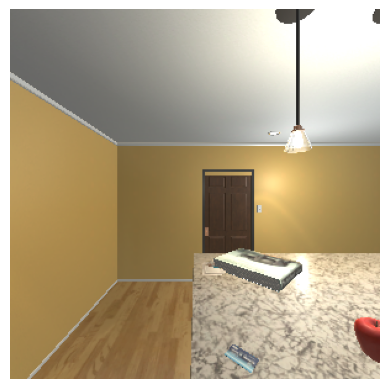

In [65]:
# event = controller.step("MoveAhead")
# event = controller.step("MoveLeft")
event = controller.step("RotateLeft")
event = controller.step("MoveAhead", moveMagnitude=0.1)
# 

plt.imshow(np.array(event.frame))
plt.axis(False);

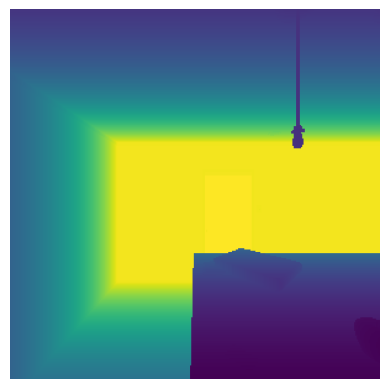

In [66]:
plt.imshow(np.array(event.depth_frame))
plt.axis(False);

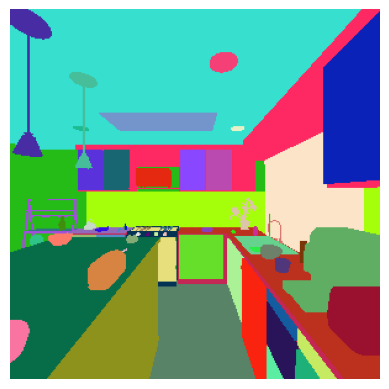

In [4]:
plt.imshow(np.array(controller.last_event.instance_segmentation_frame))
plt.axis(False);

#### Metadata
```yaml
{
    "errorMessage": {...}
    "lastActionSuccess": {...}
    "actionReturn": {...}
    "lastAction": {...}

    "sceneName": {...}
    "sceneBounds": {...}

    "agent": {...}
    "objects": {...}

    "fov": {...}
    "screenWidth": {...}
    "screenHeight": {...}
    {...}
}
```

In [12]:
print(f'error message: {controller.last_event.metadata["errorMessage"]}\n')
print(f'last action success: {controller.last_event.metadata["lastActionSuccess"]}\n')
print(f'action return: {controller.last_event.metadata["actionReturn"]}\n')
print(f'last action: {controller.last_event.metadata["lastAction"]}\n')
print(f'scene name: {controller.last_event.metadata["sceneName"]}\n')
print(f'scene bounds: {controller.last_event.metadata["sceneBounds"]}\n')
print(f'agent: {controller.last_event.metadata["agent"]}\n')
print(f'all objects in the scene: {controller.last_event.metadata["objects"]}\n')
print(f'fov: {controller.last_event.metadata["fov"]}\n')
print(f'screen width: {controller.last_event.metadata["screenWidth"]}\n')
print(f'screen height: {controller.last_event.metadata["screenHeight"]}\n')

error message: StandardIslandHeight is blocking Agent 0 from moving by (0.2500, 0.0000, 0.0000).

last action success: False

action return: None

last action: MoveAhead

scene name: FloorPlan1_physics

scene bounds: {'cornerPoints': [[2.474299907684326, 2.5999999046325684, 2.5621533393859863], [2.474299907684326, 2.5999999046325684, -2.9326725006103516], [2.474299907684326, -0.10000002384185791, 2.5621533393859863], [2.474299907684326, -0.10000002384185791, -2.9326725006103516], [-2.500056743621826, 2.5999999046325684, 2.5621533393859863], [-2.500056743621826, 2.5999999046325684, -2.9326725006103516], [-2.500056743621826, -0.10000002384185791, 2.5621533393859863], [-2.500056743621826, -0.10000002384185791, -2.9326725006103516]], 'center': {'x': -0.01287841796875, 'y': 1.2499998807907104, 'z': -0.18525958061218262}, 'size': {'x': 4.974356651306152, 'y': 2.6999998092651367, 'z': 5.494825839996338}}

agent: {'name': 'agent', 'position': {'x': -1.0, 'y': 0.900999128818512, 'z': 1.0}, 'rot

#### Agent metadata
```yaml
{
    cameraHorizon: {...},
    isStanding: {...},
    position: {...},
    rotation: {...},
    {...}
}
```

In [21]:
# controller.last_event contains the metadata of the last event
print(f'cameraHorizon: {controller.last_event.metadata["agent"]["cameraHorizon"]}\n')

print(f'is standing: {controller.last_event.metadata["agent"]["isStanding"]}\n')

print(f'agent position: {controller.last_event.metadata["agent"]["position"]}\n')

print(f'agnet rotation: {controller.last_event.metadata["agent"]["rotation"]}\n')

cameraHorizon: 0.0

is standing: True

agent position: {'x': -1.0, 'y': 0.900999128818512, 'z': 1.0}

agnet rotation: {'x': -0.0, 'y': 270.0, 'z': 0.0}



#### Object metadata
```yaml
{
    "objectId": {...},
    "objectType": {...},
    "name": {...},

    "distance": {...},
    "visible": {...},

    "position": {...},
    "rotation": {...},

    "axisAlignedBoundingBox": {...},
    "objectOrientedBoundingBox": {...},

    "mass": {...},
    "salientMaterials": {...},

    "parentReceptacles": {...},
    "receptacle": {...},
    "receptacleObjectIds": {...},

    "ObjectTemperature": {...},
    "canChangeTempToHot": {...},
    "canChangeTempToCold": {...},

    "moveable": {...},
    "isMoving": {...},

    "pickupable": {...},
    "isPickedUp": {...},

    {...Object State Changes...}
}
```

In [8]:
controller.last_event.metadata["objects"]

[{'name': 'Apple_3fef4551',
  'position': {'x': -0.46516576409339905,
   'y': 1.151225209236145,
   'z': 0.47580063343048096},
  'rotation': {'x': 0.17450670897960663,
   'y': 5.203456021263264e-05,
   'z': 0.03407910093665123},
  'visible': True,
  'isInteractable': True,
  'receptacle': False,
  'toggleable': False,
  'isToggled': False,
  'breakable': False,
  'isBroken': False,
  'canFillWithLiquid': False,
  'isFilledWithLiquid': False,
  'fillLiquid': None,
  'dirtyable': False,
  'isDirty': False,
  'canBeUsedUp': False,
  'isUsedUp': False,
  'cookable': False,
  'isCooked': False,
  'temperature': 'RoomTemp',
  'isHeatSource': False,
  'isColdSource': False,
  'sliceable': True,
  'isSliced': False,
  'openable': False,
  'isOpen': False,
  'openness': 0.0,
  'pickupable': True,
  'isPickedUp': False,
  'moveable': False,
  'mass': 0.20000000298023224,
  'salientMaterials': ['Food'],
  'receptacleObjectIds': None,
  'distance': 0.7895858287811279,
  'objectType': 'Apple',
  'o

In [13]:
import pandas as pd

def extract_object_table(controller):
    """
    Extracts a table of object types, confidence, and rounded positions
    from the provided metadata.

    Parameters:
        metadata (list): A list of dictionaries, each representing object metadata.

    Returns:
        list: A list of dictionaries, each with keys 'objectType', 'Conf', and 'Position'.
    """
    metadata = controller.last_event.metadata["objects"]
    result = []
    CONFIDENCE = 1
    for obj in metadata:
        obj_type = obj.get("objectType", "N/A")
        pos = obj.get("position", {})
        # Round each coordinate to 2 decimal places
        x = round(pos.get("x", 0), 2)
        y = round(pos.get("y", 0), 2)
        z = round(pos.get("z", 0), 2)
        position_str = f"{x}, {y}, {z}"
        result.append({
            "objectType": obj_type,
            "Conf": CONFIDENCE,
            "Position": position_str
        })
    return result

envKnowledge = extract_object_table(controller)
print(pd.DataFrame(envKnowledge))

    objectType  Conf            Position
0        Apple     1   -0.47, 1.15, 0.48
1         Book     1     0.15, 1.1, 0.62
2       Bottle     1   1.54, 0.89, -2.54
3         Bowl     1    0.27, 1.1, -0.75
4        Bread     1  -0.52, 1.17, -0.03
..         ...   ...                 ...
72      Tomato     1  -0.39, 1.14, -0.81
73        Vase     1    1.56, 0.56, -2.5
74        Vase     1   1.99, 0.56, -2.49
75      Window     1   -2.23, 1.43, -1.2
76  WineBottle     1   -1.0, 1.65, -2.58

[77 rows x 3 columns]


In [58]:
event.metadata["objects"][0]

{'name': 'Apple_3fef4551',
 'position': {'x': -0.46516576409339905,
  'y': 1.151225209236145,
  'z': 0.47580063343048096},
 'rotation': {'x': 0.17450670897960663,
  'y': 5.203456021263264e-05,
  'z': 0.03407910093665123},
 'visible': False,
 'isInteractable': False,
 'receptacle': False,
 'toggleable': False,
 'isToggled': False,
 'breakable': False,
 'isBroken': False,
 'canFillWithLiquid': False,
 'isFilledWithLiquid': False,
 'fillLiquid': None,
 'dirtyable': False,
 'isDirty': False,
 'canBeUsedUp': False,
 'isUsedUp': False,
 'cookable': False,
 'isCooked': False,
 'temperature': 'RoomTemp',
 'isHeatSource': False,
 'isColdSource': False,
 'sliceable': True,
 'isSliced': False,
 'openable': False,
 'isOpen': False,
 'openness': 0.0,
 'pickupable': True,
 'isPickedUp': False,
 'moveable': False,
 'mass': 0.20000000298023224,
 'salientMaterials': ['Food'],
 'receptacleObjectIds': None,
 'distance': 1.634577751159668,
 'objectType': 'Apple',
 'objectId': 'Apple|-00.47|+01.15|+00.48',

In [ ]:
print(f'all objects in the scene: {controller.last_event.metadata["objects"]}\n')

print(f'object id: {controller.last_event.metadata["objects"][0]["objectId"]}\n')
print(f'object type: {controller.last_event.metadata["objects"][0]["objectType"]}\n')
print(f'name: {controller.last_event.metadata["objects"][0]["name"]}\n')

print(f'distance: {controller.last_event.metadata["objects"][0]["distance"]}\n')
print(f'visible: {controller.last_event.metadata["objects"][0]["visible"]}\n')

print(f'position: {controller.last_event.metadata["objects"][0]["position"]}\n')
print(f'rotation: {controller.last_event.metadata["objects"][0]["rotation"]}\n')

print(f'axis aligned bounding box: {controller.last_event.metadata["objects"][0]["axisAlignedBoundingBox"]}\n')
print(f'object oriented bounding box: {controller.last_event.metadata["objects"][0]["objectOrientedBoundingBox"]}\n')

print(f'mass: {controller.last_event.metadata["objects"][0]["mass"]}\n')
print(f'salient materials: {controller.last_event.metadata["objects"][0]["salientMaterials"]}\n')

print(f'parent receptacles: {controller.last_event.metadata["objects"][0]["parentReceptacles"]}\n')
print(f'receptacle: {controller.last_event.metadata["objects"][0]["receptacle"]}\n')
print(f'receptacle object ids: {controller.last_event.metadata["objects"][0]["receptacleObjectIds"]}\n')

if "ObjectTemperature" in controller.last_event.metadata["objects"][0]:
	print(f'object temperature: {controller.last_event.metadata["objects"][0]["ObjectTemperature"]}\n')
else:
	print('object temperature: N/A\n')

if "canChangeTempToHot" in controller.last_event.metadata["objects"][0]:
	print(f'can change temp to hot: {controller.last_event.metadata["objects"][0]["canChangeTempToHot"]}\n')
else:
	print('can change temp to hot: N/A\n')

if "canChangeTempToCold" in controller.last_event.metadata["objects"][0]:
	print(f'can change temp to cold: {controller.last_event.metadata["objects"][0]["canChangeTempToCold"]}\n')
else:
	print('can change temp to cold: N/A\n')

print(f'moveable: {controller.last_event.metadata["objects"][0]["moveable"]}\n')
print(f'is moving: {controller.last_event.metadata["objects"][0]["isMoving"]}\n')

print(f'pickupable: {controller.last_event.metadata["objects"][0]["pickupable"]}\n')
print(f'is picked up: {controller.last_event.metadata["objects"][0]["isPickedUp"]}\n')

all objects in the scene: [{'name': 'Apple_3fef4551', 'position': {'x': -0.46516576409339905, 'y': 1.151225209236145, 'z': 0.47580063343048096}, 'rotation': {'x': 0.17450670897960663, 'y': 5.203456021263264e-05, 'z': 0.03407910093665123}, 'visible': False, 'isInteractable': False, 'receptacle': False, 'toggleable': False, 'isToggled': False, 'breakable': False, 'isBroken': False, 'canFillWithLiquid': False, 'isFilledWithLiquid': False, 'fillLiquid': None, 'dirtyable': False, 'isDirty': False, 'canBeUsedUp': False, 'isUsedUp': False, 'cookable': False, 'isCooked': False, 'temperature': 'RoomTemp', 'isHeatSource': False, 'isColdSource': False, 'sliceable': True, 'isSliced': False, 'openable': False, 'isOpen': False, 'openness': 0.0, 'pickupable': True, 'isPickedUp': False, 'moveable': False, 'mass': 0.20000000298023224, 'salientMaterials': ['Food'], 'receptacleObjectIds': None, 'distance': 1.634577751159668, 'objectType': 'Apple', 'objectId': 'Apple|-00.47|+01.15|+00.48', 'assetId': 'App

In [60]:
# Get object in specific coordinate of frame

query = controller.step(
    action="GetObjectInFrame",
    x=0.64,
    y=0.40,
    checkVisible=False
)

object_id = query.metadata["actionReturn"]
object_id

##### Get objects in view

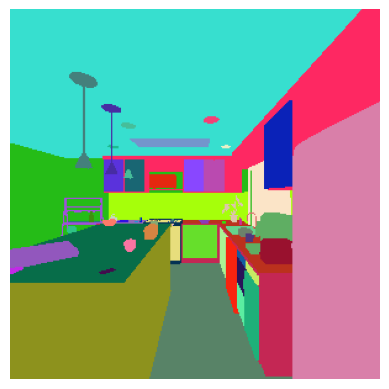

In [61]:
plt.imshow(np.array(controller.last_event.instance_segmentation_frame))
plt.axis(False);

In [62]:
segmentedColors = controller.last_event.instance_segmentation_frame
uniqueColors = np.unique(segmentedColors.reshape(-1, segmentedColors.shape[2]), axis=0)

objects_in_view = set()

for color in uniqueColors:
    color_tuple = tuple(int(c) for c in color)
    if color_tuple in event.color_to_object_id:
        objects_in_view.add(event.color_to_object_id[color_tuple])

# Print each object with coordinates converted to float values
for obj in objects_in_view:
    # Assuming the object string is formatted as "Name|x|y|z"
    parts = obj.split('|')
    if len(parts) == 4:
        name, x, y, z = parts
        try:
            # Convert string values to floats
            x_val = float(x)
            y_val = float(y)
            z_val = float(z)
        except ValueError:
            print(f"Error converting coordinates for: {obj}")
            continue
        
        # When converting to float, positive values will not display a '+'
        print(f"{name}, x: {x_val}, y: {y_val}, z: {z_val}")
    else:
        # If the format is unexpected, just print the raw string
        print(obj)


Drawer, x: -1.56, y: 0.33, z: -0.2
PepperShaker, x: 0.3, y: 0.9, z: -2.47
Spatula, x: 0.38, y: 0.91, z: -2.33
StoveBurner, x: -0.04, y: 0.92, z: -2.58
Cabinet, x: -0.73, y: 2.02, z: -2.46
Book, x: 0.15, y: 1.1, z: 0.62
CeilingLight, x: -1.2, y: 2.5, z: -0.3
Apple, x: -0.47, y: 1.15, z: 0.48
Window, x: -0.54, y: 2.595, z: -1.5
Toaster, x: -1.84, y: 0.9, z: 0.13
Bowl, x: 0.27, y: 1.1, z: -0.75
CeilingLight, x: -1.6, y: 2.5, z: -1.6
LightFixture1, x: -0.09999999, y: 2.5, z: 0.5
Cabinet, x: 0.68, y: 2.02, z: -2.46
Pan, x: 0.72, y: 0.9, z: -2.42
Cabinet, x: -1.69, y: 2.02, z: -2.46
Dishwasher, x: -1.55, y: 0.448, z: -0.718
Fridge, x: -2.1, y: 0.0, z: 1.07
HousePlant, x: -1.95, y: 0.89, z: -2.52
Pot, x: -1.22, y: 0.9, z: -2.36
Stove, x: 0.0, y: 0.0, z: 0.0
Cabinet, x: -1.55, y: 0.5, z: 0.38
StoveBurner, x: -0.47, y: 0.92, z: -2.58
StoveKnob, x: -0.48, y: 0.88, z: -2.19
Vase, x: 1.99, y: 0.56, z: -2.49
SoapBottle, x: -1.99, y: 0.9, z: -2.03
CounterTop, x: -1.87, y: 0.95, z: -1.21
Bottle, x: 1

In [64]:
event.color_to_object_id

{(231, 222, 124): 'Stove|0|0|0',
 (58, 170, 253): 'Stove',
 (150, 184, 112): 'Drawer|+00.95|+00.83|-02.20',
 (155, 30, 210): 'Drawer',
 (41, 19, 89): 'Drawer|-01.56|+00.66|-00.20',
 (25, 102, 115): 'Cabinet|+00.68|+02.02|-02.46',
 (210, 149, 89): 'Cabinet',
 (167, 137, 91): 'StoveBurner|-00.04|+00.92|-02.37',
 (156, 249, 101): 'StoveBurner',
 (10, 34, 184): 'Cabinet|-01.85|+02.02|+00.38',
 (186, 74, 176): 'Cabinet|-01.69|+02.02|-02.46',
 (243, 193, 185): 'StoveKnob|-00.48|+00.88|-02.19',
 (106, 252, 95): 'StoveKnob',
 (101, 210, 141): 'Sink|-01.90|+00.97|-01.50',
 (30, 181, 88): 'Sink',
 (90, 50, 220): 'Cabinet|+00.72|+02.02|-02.46',
 (170, 242, 149): 'Cabinet|-01.55|+00.50|-01.97',
 (81, 141, 199): 'Cabinet|+00.68|+00.50|-02.20',
 (19, 155, 196): 'Drawer|+00.95|+00.22|-02.20',
 (135, 98, 46): 'Drawer|+00.95|+00.71|-02.20',
 (80, 55, 124): 'Mug|-01.76|+00.90|-00.62',
 (8, 94, 186): 'Mug',
 (63, 150, 104): 'StoveBurner|-00.47|+00.92|-02.58',
 (91, 237, 161): 'Drawer|-01.56|+00.33|-00.20

In [65]:
def get_objects_in_view(event):
    segmentation = event.instance_segmentation_frame  # Expected shape: (H, W, 3)
    
    # Get unique colors
    # Reshape the image to (num_pixels, 3) and find unique rows.
    unique_colors = np.unique(segmentation.reshape(-1, segmentation.shape[2]), axis=0)
    
    objects_in_view = set()
    
    for color in unique_colors:
        color_tuple = tuple(int(c) for c in color)
        if color_tuple in event.color_to_object_id:
            objects_in_view.add(event.color_to_object_id[color_tuple])
    
    return list(objects_in_view)


In [66]:
get_objects_in_view(event)

['Drawer|-01.56|+00.33|-00.20',
 'PepperShaker|+00.30|+00.90|-02.47',
 'Spatula|+00.38|+00.91|-02.33',
 'StoveBurner|-00.04|+00.92|-02.58',
 'Cabinet|-00.73|+02.02|-02.46',
 'Book|+00.15|+01.10|+00.62',
 'CeilingLight|-1.2|2.5|-0.3',
 'Apple|-00.47|+01.15|+00.48',
 'Window|-0.54|2.595|-1.5',
 'Toaster|-01.84|+00.90|+00.13',
 'Bowl|+00.27|+01.10|-00.75',
 'CeilingLight|-1.6|2.5|-1.6',
 'LightFixture1|-0.09999999|2.5|0.5',
 'Cabinet|+00.68|+02.02|-02.46',
 'Pan|+00.72|+00.90|-02.42',
 'Cabinet|-01.69|+02.02|-02.46',
 'Dishwasher|-1.55|0.448|-0.718',
 'Fridge|-02.10|+00.00|+01.07',
 'HousePlant|-01.95|+00.89|-02.52',
 'Pot|-01.22|+00.90|-02.36',
 'Stove|0|0|0',
 'Cabinet|-01.55|+00.50|+00.38',
 'StoveBurner|-00.47|+00.92|-02.58',
 'StoveKnob|-00.48|+00.88|-02.19',
 'Vase|+01.99|+00.56|-02.49',
 'SoapBottle|-01.99|+00.90|-02.03',
 'CounterTop|-01.87|+00.95|-01.21',
 'Bottle|+01.54|+00.89|-02.54',
 'CounterTop|+00.69|+00.95|-02.48',
 'Lettuce|-01.81|+00.97|-00.94',
 'ShelvingUnit|+01.75|+00

In [67]:
query = controller.step(
    action="GetObjectInFrame",
    x=0.5,
    y=0.5,
    checkVisible=False
)

object_id = query.metadata["actionReturn"]

In [68]:
query

<ai2thor.server.Event at 0x76ae1f1e68d0
    .metadata["lastAction"] = GetObjectInFrame
    .metadata["lastActionSuccess"] = False
    .metadata["errorMessage"] = "InvalidOperationException: no sim objects found at (0.5,0.5). trace:   at UnityStandardAssets.Characters.FirstPerson.BaseFPSAgentController.screenToWorldTarget (System.Single x, System.Single y, SimObjPhysics& target, UnityEngine.RaycastHit& hit, System.Boolean forceAction, System.Boolean checkVisible) [0x000d1] in <40d6a6c54fa349fab67f7470c3432f83>:0    at UnityStandardAssets.Characters.FirstPerson.BaseFPSAgentController.screenToWorldTarget (System.Single x, System.Single y, SimObjPhysics& target, System.Boolean forceAction, System.Boolean checkVisible) [0x00008] in <40d6a6c54fa349fab67f7470c3432f83>:0    at UnityStandardAssets.Characters.FirstPerson.BaseFPSAgentController.GetObjectInFrame (System.Single x, System.Single y, System.Boolean checkVisible) [0x00002] in <40d6a6c54fa349fab67f7470c3432f83>:0    at (wrapper managed-

# Process Sensory Inputs

## Vision branch

### Literature

### Object detection

#### YOLO

##### Compare YOLOv8 Models

In [ ]:
import time
from ultralytics import YOLO

In [16]:
# Provide the image path for inference.
img_path = np.array(controller.last_event.frame)

In [9]:
model8s = YOLO("models/YOLO/yolov8s.pt")

In [10]:

results = model8s(np.array(controller.last_event.frame))
results[0].show()



0: 640x640 1 sports ball, 1 cup, 1 bowl, 1 potted plant, 1 microwave, 1 oven, 1 sink, 13.3ms
Speed: 2.3ms preprocess, 13.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Opening in existing browser session.


In [ ]:
results = model8s(np.array(controller.last_event.frame))
results[0].show()
for box in results[0].boxes:
    x, y, w, h = box.xywh[0]
    confidence = box.conf[0]
    if confidence > 0.5:
        class_name = model8s.names[int(box.cls[0].item())]
        print(f"{class_name} at ({x:.2f}, {y:.2f}) with confidence {confidence:.2f}")


0: 640x640 1 sports ball, 1 cup, 1 bowl, 1 potted plant, 1 microwave, 1 oven, 1 sink, 13.4ms
Speed: 17.8ms preprocess, 13.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
oven at (118.67, 196.66) with confidence 0.85
potted plant at (186.06, 163.65) with confidence 0.74


Opening in existing browser session.


In [ ]:
# ----------------------------
# Step 1: Build and Clean Unique Object Names from the Scene
# ----------------------------
# Get the list of objects from the scene metadata
objects = controller.last_event.metadata["objects"]

# Dictionary to hold unique objects keyed by object name.
# This assumes that the "name" field uniquely identifies an object.
unique_objects = {}
for obj in objects:
    name = obj.get('name')
    # Use the axisAlignedBoundingBox center if available, else use the position.
    center_info = obj.get('axisAlignedBoundingBox', {}).get('center', obj.get('position'))
    # Ensure that center_info exists and contains both x and y values.
    if center_info is not None and 'x' in center_info and 'y' in center_info:
        if name not in unique_objects:
            unique_objects[name] = (center_info['x'], center_info['y'])

# Clean object names by removing everything after (and including) the underscore.
# For example, "Apple_3fef4551" becomes "Apple".
cleaned_class_names = [name.split('_')[0] for name in unique_objects.keys()]
print("Cleaned unique object names (class_names):")
print(cleaned_class_names)

# ----------------------------
# Step 2: Load YOLOv8 Models
# ----------------------------
model8n = YOLO("models/YOLO/yolov8n.pt")
model8s = YOLO("models/YOLO/yolov8s.pt")
model8m = YOLO("models/YOLO/yolov8m.pt")
model8l = YOLO("models/YOLO/yolov8l.pt")
model8x = YOLO("models/YOLO/yolov8x.pt")

# Pack the models in a list for easy iteration.
models = [
    ("YOLOv8n", model8n),
    ("YOLOv8s", model8s),
    ("YOLOv8m", model8m),
    ("YOLOv8l", model8l),
    ("YOLOv8x", model8x)
]

# ----------------------------
# Step 3: Run Inference on an Image and Measure Detection Time
# ----------------------------
for model_name, model in models:
    print(f"\n--- Detections using {model_name} ---")
    start_time = time.time()  # Start timer
    
    results = model(img_path)  # Run inference
    
    end_time = time.time()  # End timer
    detection_time = end_time - start_time
    print(f"Detection time for {model_name}: {detection_time:.3f} seconds")
    
    # Process and print each detection in a YOLO-like format.
    # Note: YOLO models output indices corresponding to their trained classes.
    # Here, we map the detected class index to our cleaned object names if possible.
    for result in results:
        for box in result.boxes:
            # Extract bounding box (xywh), confidence, and class index.
            x, y, w, h = box.xywh[0]
            confidence = box.conf[0]
            class_index = int(box.cls[0].item())
            
            # Map the class index to our cleaned unique object names.
            if class_index < len(cleaned_class_names):
                label = cleaned_class_names[class_index]
            else:
                label = "Unknown"
            
            print(f"Label: {label}, Confidence: {confidence:.2f}, BBox: ({x:.1f}, {y:.1f}, {w:.1f}, {h:.1f})")

Cleaned unique object names (class_names):
['Apple', 'Book', 'Bottle', 'Bowl', 'Bread', 'ButterKnife', 'Cabinet', 'Cabinet', 'Cabinet', 'Cabinet', 'Cabinet', 'Cabinet', 'Cabinet', 'Cabinet', 'Cabinet', 'CoffeeMachine', 'CounterTop', 'CounterTop', 'CounterTop', 'CreditCard', 'Cup', 'DishSponge', 'Drawer', 'Drawer', 'Drawer', 'Drawer', 'Drawer', 'Drawer', 'Drawer', 'Drawer', 'Drawer', 'Egg', 'Faucet', 'Floor', 'Fork', 'Fridge', 'GarbageCan', 'HousePlant', 'Kettle', 'Knife', 'Lettuce', 'LightSwitch', 'Microwave', 'Mug', 'Pan', 'PaperTowelRoll', 'PepperShaker', 'Plate', 'Pot', 'Potato', 'SaltShaker', 'Shelf', 'Shelf', 'Shelf', 'ShelvingUnit', 'Sink', 'SinkBasin', 'SoapBottle', 'Spatula', 'Spoon', 'Statue', 'Stool', 'Stool', 'StoveBurner', 'StoveBurner', 'StoveBurner', 'StoveBurner', 'StoveKnob', 'StoveKnob', 'StoveKnob', 'StoveKnob', 'Toaster', 'Tomato', 'Vase', 'Vase', 'Window', 'WineBottle']

--- Detections using YOLOv8n ---

0: 640x640 1 bowl, 1 chair, 1 potted plant, 1 dining table, 1 

##### YOLO object extraction

###### Get unique objects in the environment

In [13]:
# Extract the list of objects from the last event metadata.
objects = controller.last_event.metadata.get("objects", [])

# Use a set comprehension to extract unique object types.
unique_object_types = list(set([obj["objectType"] for obj in objects if "objectType" in obj]))

unique_object_types

['CounterTop',
 'Fridge',
 'Kettle',
 'CreditCard',
 'Shelf',
 'Microwave',
 'Floor',
 'PaperTowelRoll',
 'Statue',
 'PepperShaker',
 'Window',
 'Vase',
 'Drawer',
 'SoapBottle',
 'LightSwitch',
 'Fork',
 'Spoon',
 'Stool',
 'Lettuce',
 'StoveBurner',
 'Potato',
 'SinkBasin',
 'ShelvingUnit',
 'Spatula',
 'Mug',
 'WineBottle',
 'Egg',
 'SaltShaker',
 'Knife',
 'Tomato',
 'Bowl',
 'DishSponge',
 'Plate',
 'GarbageCan',
 'Pot',
 'Book',
 'Bread',
 'ButterKnife',
 'Sink',
 'Pan',
 'Bottle',
 'HousePlant',
 'StoveKnob',
 'CoffeeMachine',
 'Toaster',
 'Apple',
 'Cup',
 'Cabinet',
 'Faucet']

### Environment Knowledge

In [2]:
import time
import math
import numpy as np
import pandas as pd
import yaml
import os
import base64
import requests
import io
from PIL import Image
import cv2
import re
import networkx as nx

from ai2thor.controller import Controller
from ultralytics import YOLO
# from openai import OpenAI  # if needed
from sentence_transformers import SentenceTransformer, util

import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:

def boxDepth(x, y, w, h, controller):
    vMin = y - h//2
    vMax = y + h//2
    hMin = x - w//2
    hMax = x + w//2
    depthFrame = controller.last_event.depth_frame
    boxDepth = np.percentile(depthFrame[vMin:vMax, hMin:hMax], 90)
    return round(boxDepth, 1)


def rotate_point(x_cam, z_cam, yaw_deg):
    # Convert yaw angle to radians.
    yaw_rad = np.deg2rad(yaw_deg)
    # Build the rotation matrix for yaw.
    R = np.array([[np.cos(yaw_rad), -np.sin(yaw_rad)],
                  [np.sin(yaw_rad),  np.cos(yaw_rad)]])
    rotated = R.dot(np.array([x_cam, z_cam]))
    return rotated[0], rotated[1]


def coord23D(x, y, w, h, controller):
    image_width = 300  # controller.last_event.frame.shape[1]
    image_height = 300 # controller.last_event.frame.shape[0]
    h_fov = v_fov = 90
    
    center_u = image_width / 2.0  # 150
    center_v = image_height / 2.0  # 150

    # Angular resolution: degrees per pixel.
    angle_per_pixel_h = (h_fov / 2.0) / center_u  # 0.3 degrees per pixel
    angle_per_pixel_v = (v_fov / 2.0) / center_v    # 0.3 degrees per pixel

    # Angular offsets from the center (in degrees).
    theta_h_deg = (x - center_u) * angle_per_pixel_h
    theta_v_deg = (y - center_v) * angle_per_pixel_v

    # Convert angles to radians.
    theta_h = np.deg2rad(theta_h_deg)
    theta_v = np.deg2rad(theta_v_deg)

    # Compute the depth of the object.
    d = boxDepth(x, y, w, h, controller)
    
    # Compute 3D coordinates in the camera frame.
    # Using the convention: optical axis is z, x is to the right, and y is upward.
    x_cam = d * np.sin(theta_h) * np.cos(theta_v)
    y_cam = d * np.sin(theta_v)  # if image v increases downward, you might need to flip sign
    z_cam = d * np.cos(theta_h) * np.cos(theta_v)
    
    # Incorporate robot's rotation:
    robot_yaw_deg = controller.last_event.metadata["agent"]["rotation"]["y"]
    # Rotate x_cam and z_cam from the camera frame to align with global axes.
    x_rot, z_rot = rotate_point(x_cam, z_cam, robot_yaw_deg)

    # Compute global coordinates by applying the robot's global position.
    x_global = controller.last_event.metadata["agent"]["position"]["x"] - x_rot
    y_global = controller.last_event.metadata["agent"]["position"]["y"] - y_cam
    z_global = controller.last_event.metadata["agent"]["position"]["z"] - z_rot
    
    return x_global, y_global, z_global


def visionBranch(model, itemDF, controller, confThr=0.3):
    """
    Updates itemDF with YOLO object detection results and depth estimation.
    
    For each detection:
      - Compute the 3D coordinate (via coord23D).
      - If an object with the same type exists in itemDF, check its position.
        If the Euclidean distance is less than 0.5, update that entry by averaging the positions.
      - Otherwise, append a new row.
    """
   
    results = model(np.array(controller.last_event.frame))
    
    for box in results[0].boxes:
        # Get xywh coordinates and confidence from the detection.
        x, y, w, h = box.xywh[0]
        confidence = box.conf[0].item()  # Convert confidence from tensor to float.
        if confidence > confThr:
            # Get the actual object name using the model's names dictionary.
            className = model.names[int(box.cls[0].item())]
            x, y, w, h = round(x.item()), round(y.item()), round(w.item()), round(h.item())
            
            # Compute the global 3D coordinate for this detection.
            x_cam, y_cam, z_cam = coord23D(x, y, w, h, controller)
            new_position = np.array([x_cam, y_cam, z_cam])
            
            updated = False
            # Check if an entry with the same object type already exists in itemDF.
            for idx, row in itemDF.iterrows():
                if row['objectType'] == className:
                    # Convert the stored string "x, y, z" to a numpy array.
                    existing_position = np.array([float(val.strip()) for val in row['Position'].split(',')])
                    # Compute the Euclidean distance.
                    dist = np.linalg.norm(new_position - existing_position)
                    if dist < 0.5:
                        # Average the two positions.
                        avg_position = (new_position + existing_position) / 2.0
                        itemDF.at[idx, 'Position'] = f"{avg_position[0]}, {avg_position[1]}, {avg_position[2]}"
                        updated = True
                        break
            # If no similar object exists, append a new entry.
            if not updated:
                new_row = pd.DataFrame({
                    "objectType": [className],
                    "Conf": [confidence],
                    "Position": [f"{x_cam}, {y_cam}, {z_cam}"]
                })
                itemDF = pd.concat([itemDF, new_row], ignore_index=True)
                
    return itemDF


def add_goal_similarity(table, goal_phrase):
    """
    Computes the cosine similarity between each object's type and a goal phrase,
    adds the similarity as a 'goalSim' key, and sorts the table by (Conf * goalSim)
    in descending order.
    
    Parameters:
        table (list): A list of dictionaries representing objects with keys 'objectType', 'Conf', and 'Position'.
        goal_phrase (str): The phrase to compare against (default: "burning smell").
    
    Returns:
        list: The updated and sorted table with an added 'goalSim' column.
    """
    # Load the pre-trained Sentence Transformer model
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Compute the embedding for the goal phrase once
    goal_embedding = model.encode(goal_phrase, convert_to_tensor=True)
    
    # For each object in the table, compute cosine similarity between the object type and the goal phrase.
    for row in table:
        # Encode the object type to obtain its embedding
        object_embedding = model.encode(row["objectType"], convert_to_tensor=True)
        # Compute cosine similarity
        cosine_sim = util.pytorch_cos_sim(object_embedding, goal_embedding).item()
        # Add the computed similarity to the row
        row["goalSim"] = cosine_sim
    
    # Sort the table by the product of 'Conf' and 'goalSim' in descending order
    table.sort(key=lambda x: x["Conf"] * x["goalSim"], reverse=True)
    return table

itemColumns = ["objectType", "Conf", "Position"]
itemDF = pd.DataFrame(columns=itemColumns)

yolo_model = YOLO("models/YOLO/yolov8s.pt")

for i in range(4):
    itemDF = visionBranch(yolo_model, itemDF, controller)
    itemDF_list = itemDF.to_dict(orient='records')
    itemDF_list = add_goal_similarity(itemDF_list, "burning smell")
    itemDF = pd.DataFrame(itemDF_list)
    print(itemDF)
    print("\n")
    
    controller.step(
        "RotateLeft",
    )



0: 640x640 1 umbrella, 1 bowl, 1 chair, 1 potted plant, 3 microwaves, 1 oven, 2 sinks, 13.1ms
Speed: 2.7ms preprocess, 13.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


/tmp/ipykernel_4621/2407728585.py:110: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  itemDF = pd.concat([itemDF, new_row], ignore_index=True)


     objectType      Conf                                           Position  \
0          oven  0.878272  -1.6160910018907875, -0.004867529040310625, 4....   
1  potted plant  0.764473  -0.23178376439312942, 0.6028545687939224, 4.70...   
2     microwave  0.801031  -0.5188168132278239, 0.4428618667796709, 1.607...   
3     microwave  0.593213  -1.652636147238617, 1.1659799909671975, 4.6832...   
4         chair  0.471666  -3.1853253927396046, 0.44447914697542396, 4.07...   
5          sink  0.346252  -0.25233358793668237, 0.2832109883049192, 3.73...   
6          bowl  0.477165  -1.9542409286208233, 0.5544595982520413, 2.486...   

    goalSim  
0  0.264848  
1  0.248836  
2  0.199175  
3  0.199175  
4  0.218985  
5  0.238352  
6  0.126805  



0: 640x640 1 airplane, 13.1ms
Speed: 1.9ms preprocess, 13.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
     objectType      Conf                                           Position  \
0          oven  0.878272  -1.6160910

In [ ]:
def main():
    stepMagnitude = 0.25
            

    
    cv2.namedWindow("AI2-THOR", cv2.WINDOW_NORMAL)
    
    controller = Controller(
        agentMode="default",
        visibilityDistance=1.5,
        scene="FloorPlan1",
        gridSize=0.25,
        snapToGrid=True,
        rotateStepDegrees=90,
        renderDepthImage=True,
        renderInstanceSegmentation=True,
        width=300,
        height=300,
        fieldOfView=90
    )
    
    # goal = "smoke"
    # target_items = ["Microwave"]
    
    goal = "rotten smell"
    target_items = ["GarbageCan"]
    
    objects = controller.last_event.metadata["objects"]
    sourcePos = get_objects_centers(objects, target_items)

    # Obtain current scene objects.
    # if target_items == ['Microwave']:
    #     x, y, z = sourcePos[0]
    #     z += 0.5
    #     sourcePos = np.array([[x, y, z]])
    # elif target_items == ['GarbageCan']:
    #     x, y, z = sourcePos[0]
    #     x += 0.25
    #     sourcePos = np.array([[x, y, z]])
        

    # # Microwave Starting position 1
    # controller.step(
    #     action="Teleport",
    #     position=dict(x=1.5, y=0.9, z=1.5),
    #     rotation=dict(x=0, y=180, z=0)
    # )

    # controller.step(
    #     "MoveAhead",
    #     moveMagnitude=0.01
    # )
    
    # # Microwave Starting position 2
    # controller.step(
    #     action="Teleport",
    #     position=dict(x=2, y=0.9, z=0),
    #     rotation=dict(x=0, y=0, z=0)
    # )

    # controller.step(
    #     "MoveAhead",
    #     moveMagnitude=0.01
    # )
    
    # # Microwave Starting position 3
    # controller.step(
    #     action="Teleport",
    #     position=dict(x=-1, y=0.9, z=2),
    #     rotation=dict(x=0, y=0, z=0)
    # )

    # controller.step(
    #     "MoveAhead",
    #     moveMagnitude=0.01
    # )
    
    
    # # Garbage Start Pos 1: facing back to the garbage bin
    # controller.step(
    #     action="Teleport",
    #     position=dict(x=1.5, y=0.9, z=2),
    #     rotation=dict(x=0, y=90, z=0),
    # )

    # controller.step(
    #     "MoveAhead",
    #     moveMagnitude=0.01
    # )

    # Garbage Start Pos 2: upper left corner
    controller.step(
        action="Teleport",
        position=dict(x=2, y=0.9, z=-1.5),
        rotation=dict(x=0, y=180, z=0),
    )

    controller.step(
        "MoveAhead",
        moveMagnitude=0.01
    )


    # # Garbage Start Pos 3:
    # controller.step(
    #     action="Teleport",
    #     position=dict(x=-1, y=0.9, z=-1.5),
    #     rotation=dict(x=0, y=90, z=0),
    # )

    # controller.step(
    #     "MoveAhead",
    #     moveMagnitude=0.01
    # )

    fusion_control(
        controller=controller,
        itemDF=itemDF,
        yolo_model=yolo_model,
        # api_key=api_key,
        # gpt_model=gpt_model,
        source_position=sourcePos,
        save_path="save/itemDF.csv",
        max_time=200,
        goal_phrase=goal,
        dist_threshold=1.2,
        stepMagnitude=stepMagnitude
    )

if __name__ == "__main__":
    main()


#### CLIP

In [218]:
clipModel = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clipProcessor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [219]:
labels=["kitchen",
        "living room",
        "bed room",
        "bathroom"]

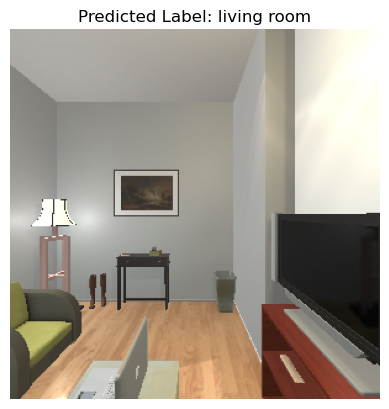

In [220]:
inputs = clipProcessor(labels, images=np.array(controller.last_event.frame), return_tensors="pt", padding=True)

outputs = clipModel(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

hiProbLabel = labels[torch.argmax(probs).item()]

plt.imshow(np.array(controller.last_event.frame));
plt.axis(False);
plt.title("Predicted Label: " + hiProbLabel);

### Visual mapping

#### Demo mapping

In [ ]:
import numpy as np

def get_global_object_coords(query_object_name, detections,
                             image_width=300, image_height=300,
                             h_fov=90, v_fov=90, camera_offset=(0, 0, 0)):
    """
    Get the 3D global coordinates of an object detected in the current frame.
    
    This function:
      1. Queries the agent's global position from controller.last_event.metadata["agent"]["position"].
      2. Searches for the object by name in the detections list (each detection must have 'name', 'midpoint', and 'avg_depth').
      3. Computes the object's 3D coordinates in the camera (or agent) frame using its bounding box midpoint and depth.
      4. Converts these coordinates to global coordinates by adding the agent's position.
    
    Parameters:
      query_object_name : str
          The name of the object to search for.
      detections : list of dict
          Each detection dictionary must include:
             - 'name': object name
             - 'midpoint': tuple (u, v) representing the bounding box center in pixel coordinates
             - 'avg_depth': the average depth (in meters) for that detection.
      image_width : int
          Width of the image in pixels (default: 300).
      image_height : int
          Height of the image in pixels (default: 300).
      h_fov : float
          Horizontal field of view in degrees (default: 90).
      v_fov : float
          Vertical field of view in degrees (default: 90).
      camera_offset : tuple of floats (x, y, z)
          Optional offset of the camera relative to the agent's reference point (default: (0, 0, 0)).
    
    Returns:
      numpy.ndarray or None:
          The object's global 3D coordinates [x, y, z] as a NumPy array, or None if the object is not found
          or has invalid depth information.
    """
    # Query the agent's global position.
    agent_position = controller.last_event.metadata["agent"]["position"]

    # Search through detections for the desired object.
    detection = None
    for det in detections:
        if det['name'] == query_object_name:
            detection = det
            break
    if detection is None:
        print(f"Object '{query_object_name}' not found in detections.")
        return None
    if detection.get('avg_depth') is None:
        print(f"No valid depth information for '{query_object_name}'.")
        return None

    # Extract pixel coordinates and depth.
    u, v = detection['midpoint']
    depth = detection['avg_depth']

    # Calculate the image center.
    center_u = image_width / 2.0
    center_v = image_height / 2.0

    # Determine angular resolution (degrees per pixel).
    angle_per_pixel_h = (h_fov / 2.0) / center_u
    angle_per_pixel_v = (v_fov / 2.0) / center_v

    # Calculate angular offsets (in degrees) from the center.
    theta_h_deg = (u - center_u) * angle_per_pixel_h
    theta_v_deg = (v - center_v) * angle_per_pixel_v

    # Convert angles to radians.
    theta_h = np.deg2rad(theta_h_deg)
    theta_v = np.deg2rad(theta_v_deg)

    # Compute the object's 3D coordinates in the camera frame.
    # Assumption: camera's X axis points forward, Y axis points right, Z axis points downward.
    x_cam = depth * np.cos(theta_v) * np.cos(theta_h) + camera_offset[0]
    y_cam = depth * np.cos(theta_v) * np.sin(theta_h) + camera_offset[1]
    z_cam = depth * np.sin(theta_v) + camera_offset[2]
    object_cam_coords = np.array([x_cam, y_cam, z_cam])

    # Convert to global coordinates by adding the agent's global position.
    agent_global = np.array([agent_position['x'], agent_position['y'], agent_position['z']])
    object_global_coords = agent_global + object_cam_coords

    print(f"Global 3D coordinates for '{query_object_name}': {object_global_coords}")
    return object_global_coords

# --- Example usage ---
if __name__ == '__main__':
    # Example detections list.
    detections = [
        {
            'name': 'houseplant',
            'bbox': [101.28, 179.29, 108.58, 184.84],
            'confidence': 0.85,
            'avg_depth': 2.0,
            'midpoint': (105, 182)
        },
        # ... additional detections ...
    ]
    
    query_object_name = "houseplant"
    global_coords = get_global_object_coords(query_object_name, detections)

Global 3D coordinates for 'houseplant': [    0.91751     0.44065      1.3335]


In [66]:
import numpy as np

def pixel_to_3d(u, v, d, image_width, image_height, h_fov=90, v_fov=90, camera_offset=(0,0,0)):
    """
    Convert pixel coordinates (u, v) with a depth measurement to 3D coordinates in the camera frame.
    
    Parameters:
      u, v         : Pixel coordinates in the image.
      d            : Depth measurement (meters).
      image_width  : Width of the image in pixels.
      image_height : Height of the image in pixels.
      h_fov        : Horizontal field of view in degrees.
      v_fov        : Vertical field of view in degrees.
      camera_offset: Optional (x, y, z) offset of the camera relative to the robot's reference point.
    
    Returns:
      A numpy array with the 3D coordinates (x, y, z) in the camera coordinate frame.
    """
    # Compute the centers of the image.
    center_u = image_width / 2.0
    center_v = image_height / 2.0

    # Compute angular resolutions for horizontal and vertical directions.
    angle_per_pixel_h = (h_fov / 2.0) / center_u  # degrees per pixel horizontally
    angle_per_pixel_v = (v_fov / 2.0) / center_v   # degrees per pixel vertically

    # Calculate the angular offsets (in degrees) from the center.
    theta_h_deg = (u - center_u) * angle_per_pixel_h
    theta_v_deg = (v - center_v) * angle_per_pixel_v

    # Convert angles to radians.
    theta_h = np.deg2rad(theta_h_deg)
    theta_v = np.deg2rad(theta_v_deg)

    # Compute the 3D coordinates in the camera frame.
    x_cam = d * np.cos(theta_v) * np.cos(theta_h)
    y_cam = d * np.cos(theta_v) * np.sin(theta_h)
    z_cam = d * np.sin(theta_v)

    # Apply any camera offset.
    x_cam += camera_offset[0]
    y_cam += camera_offset[1]
    z_cam += camera_offset[2]

    return np.array([x_cam, y_cam, z_cam])


def get_object_3d_coords(query_object_name, detections, image_width=300, image_height=300, h_fov=90, v_fov=90):
    """
    Query a specific object by its name from the detections list and convert its midpoint 
    (with associated depth) to 3D coordinates using the pixel_to_3d function.

    Parameters:
      query_object_name : The name of the object to search for.
      detections        : A list of detection dictionaries.
      image_width       : The width of the image in pixels (default is 300).
      image_height      : The height of the image in pixels (default is 300).
      h_fov             : Horizontal field of view in degrees (default is 90).
      v_fov             : Vertical field of view in degrees (default is 90).

    Returns:
      A numpy array with the object's 3D coordinates (x, y, z) if found and valid;
      otherwise, returns None.
    """
    queried_detection = None
    # Search through the detections for the object.
    for detection in detections:
        if detection['name'] == query_object_name:
            queried_detection = detection
            break

    if queried_detection is None:
        print(f"Object '{query_object_name}' not found in detections.")
        return None

    # Extract the midpoint and average depth from the queried detection.
    midpoint = queried_detection['midpoint']  # (u, v)
    avg_depth = queried_detection['avg_depth']
    
    if avg_depth is None:
        print(f"No valid depth information for '{query_object_name}'.")
        return None

    # Compute the 3D coordinates using the midpoint and depth.
    object_3d_coords = pixel_to_3d(midpoint[0], midpoint[1], avg_depth,
                                   image_width, image_height,
                                   h_fov, v_fov)
    
    print(f"3D coordinates for '{query_object_name}': {object_3d_coords}")
    return object_3d_coords

# Example usage:
if __name__ == '__main__':
    # Assume that `detections` is already defined as in your previous code.
    # For example:
    # detections = [
    #     {'name': 'person', 'bbox': [101.28, 179.29, 108.58, 184.84],
    #      'confidence': 0.85, 'avg_depth': 2.0, 'midpoint': (105, 182)},
    #     ... (other detections) ...
    # ]
    query_object_name = "houseplant"  # Replace with the desired object name.
    coords = get_object_3d_coords(query_object_name, detections)


3D coordinates for 'houseplant': [     1.9175    -0.46035     0.33354]


#### Get detected objects

In [7]:
def get_objects_by_type(object_type_keyword):
    """
    Filters and returns scene objects whose 'objectType' field contains the given keyword.
    
    Parameters:
        object_type_keyword (str): The keyword to search for in the object type.
        
    Returns:
        list: A list of dictionaries representing objects whose 'objectType'
              includes the keyword (case-insensitive).
    """
    # Retrieve all objects from the scene metadata.
    all_objects = controller.last_event.metadata.get("objects", [])
    
    # Filter the objects using a list comprehension.
    filtered_objects = [
        obj for obj in all_objects
        if object_type_keyword.lower() in obj.get("objectType", "").lower()
    ]
    
    return filtered_objects

# Example usage:
if __name__ == "__main__":
    # Filter for objects whose type includes "fridge" (e.g., 'Fridge', 'Refrigerator', etc.)
    object = "HousePlant"
    fridge_objects = get_objects_by_type(object)
    
    print(f"Filtered objects (matching {object}):")
    for obj in fridge_objects:
        print(obj)

    object = "Microwave"
    fridge_objects = get_objects_by_type(object)
    
    print(f"Filtered objects (matching {object}):")
    for obj in fridge_objects:
        print(obj)


Filtered objects (matching HousePlant):
{'name': 'HousePlant_cc99edda', 'position': {'x': -1.9487520456314087, 'y': 0.8894974589347839, 'z': -2.5208652019500732}, 'rotation': {'x': -1.6810812667245045e-05, 'y': 5.334290504455566, 'z': 7.305232429644093e-05}, 'visible': False, 'isInteractable': False, 'receptacle': False, 'toggleable': False, 'isToggled': False, 'breakable': False, 'isBroken': False, 'canFillWithLiquid': True, 'isFilledWithLiquid': False, 'fillLiquid': None, 'dirtyable': False, 'isDirty': False, 'canBeUsedUp': False, 'isUsedUp': False, 'cookable': False, 'isCooked': False, 'temperature': 'RoomTemp', 'isHeatSource': False, 'isColdSource': False, 'sliceable': False, 'isSliced': False, 'openable': False, 'isOpen': False, 'openness': 0.0, 'pickupable': False, 'isPickedUp': False, 'moveable': True, 'mass': 3.0, 'salientMaterials': ['Ceramic', 'Organic'], 'receptacleObjectIds': None, 'distance': 3.6464715003967285, 'objectType': 'HousePlant', 'objectId': 'HousePlant|-01.95|+0

#### Mapping attempts

In [ ]:
def depth(x_coord: int, y_coord: int):
    fov = 90  # Horizontal field of view
    image_width = 300  # Image width in pixels
    center_x = image_width / 2.0
    angle_per_pixel = fov / image_width
    if x_coord < center_x:
        theta = (center_x - x_coord) * angle_per_pixel
    else:
        theta = (x_coord - center_x) * angle_per_pixel
    straightDepth = float(depthFrame[round(x_coord), round(y_coord)])
    hDepth = straightDepth #/ np.cos(theta)
    return hDepth


def hThetaCalc(x_coord: float):
    # Calculate the angle theta
    h_fov = 90  # Horizontal field of view
    image_width = 300  # Image width in pixels
    center_x = image_width / 2.0
    angle_per_pixel = h_fov / image_width
    robotRot = int(controller.last_event.metadata["agent"]["rotation"]["y"])
    if x_coord < center_x:
        theta = robotRot - (center_x - x_coord) * angle_per_pixel
    else:
        theta = robotRot + (x_coord - center_x) * angle_per_pixel
    return theta


def vThetaCalc(y_coord: float):
    # Calculate the angle theta
    v_fov = 90  # Horizontal field of view
    image_height = 300  # Image width in pixels
    center_y = image_height / 2.0
    angle_per_pixel = v_fov / image_height
    if y_coord < center_y:
        theta = (center_y - y_coord) * angle_per_pixel
    else:
        theta = (y_coord - center_y) * angle_per_pixel
    return theta


def getGlobalCoords(x_coord: int, y_coord: int, depth: float):
    # Calculate the global coordinates
    hTheta = hThetaCalc(x_coord)
    vTheta = vThetaCalc(y_coord)
    agent_x = controller.last_event.metadata["agent"]["position"]["x"]
    agent_y = controller.last_event.metadata["agent"]["position"]["y"]
    agent_z = controller.last_event.metadata["agent"]["position"]["z"]
    global_z = agent_z + depth * np.sin(np.radians(hTheta))
    global_x = agent_x + depth * np.cos(np.radians(hTheta))
    global_y = agent_y + depth * np.cos(np.radians(vTheta))
    return round(global_x,2), round(global_y,2), round(global_z,2)

depthFrame = controller.last_event.depth_frame

# house plant
x_coord = 186.07
y_coord = 163.66
pointDepth = float(depthFrame[round(x_coord), round(y_coord)])
global_x, global_y, global_z = getGlobalCoords(x_coord, y_coord, pointDepth)
print(f'x: {global_x}, y: {global_y}, z: {global_z}')


# microwave
x_coord = 118.14
y_coord = 197.17
pointDepth = float(depthFrame[round(x_coord), round(y_coord)])
global_x, global_y, global_z = getGlobalCoords(x_coord, y_coord, pointDepth)
print(f'x: {global_x}, y: {global_y}, z: {global_z}')

x: -4.37, y: 4.33, z: 0.61
x: -3.68, y: 3.53, z: 1.7


In [ ]:
# Get object centers
def get_objects_depth(objects, target_names):
    """
    Returns depth value at a given coordinate from the depth frame.
        
    Parameters:
        x, z (int): The pixel coordinates (x, z) to retrieve the depth value.
        
    Returns:
        int: The depth value at the specified pixel coordinates.
    """
                
    return np.array(centers)

# Example usage:
# Assume controller.last_event.metadata["objects"] holds the scene objects.
objects = controller.last_event.metadata["objects"]

# To get the centers of objects whose name includes either "Apple" or "Bread":
target_items = ["Toaster"]
object_centers = get_objects_centers(objects, target_items)
print("Centers of specified objects as a tensor:")
print(object_centers)


#### Probably good

##### Get yolo bounding box coordinate and micpoints

In [4]:
import time
from ultralytics import YOLO

##### Get depth

In [5]:
def yoloCoord(model, object):
    results = model(np.array(controller.last_event.frame))
    for box in results[0].boxes:
        x, y, w, h = box.xywh[0]
        confidence = box.conf[0]
        if confidence > 0.5:
            class_name = model.names[int(box.cls[0].item())]
            if class_name == object:
                return int(x), int(y), int(w), int(h)
    return

def pointDepth(hCoord: int, vCoord: int):
    depthFrame = controller.last_event.depth_frame
    pointDepth = float(depthFrame[round(int(vCoord)), round(int(hCoord))])
    return round(pointDepth, 2)

# Convert coordinates to integers
x_coord = 118.0 # for oven
y_coord = 197

# x_coord = 186.07 # for potted plant
# y_coord = 163.66

# TODO: check 4 corner points and take the highest depth value
# TODO: other implementations

def boxDepth(x, y, w, h):
    vMin = y - h//2
    vMax = y + h//2
    hMin = x - w//2
    hMax = x + w//2
    depthFrame = controller.last_event.depth_frame
    boxDepth = np.percentile(depthFrame[vMin:vMax, hMin:hMax], 90)
    return round(boxDepth, 1)

# model = YOLO("models/YOLO/yolov8s.pt")
model = YOLO("models/YOLO/yolov8m.pt")
object = "microwave"

x, y, w, h = yoloCoord(model, object)

print(f'x: {x}, y: {y}, w: {w}, h: {h}\n')

print(f'Point depth: {pointDepth(x, y)}\n')
print(f'Box depth: {boxDepth(x, y, w, h)}\n')


0: 640x640 1 umbrella, 1 cup, 2 bowls, 1 broccoli, 2 potted plants, 2 microwaves, 2 ovens, 1 sink, 1 clock, 28.7ms
Speed: 7.7ms preprocess, 28.7ms inference, 156.9ms postprocess per image at shape (1, 3, 640, 640)
x: 117, y: 136, w: 39, h: 21

Point depth: 3.67

Box depth: 3.799999952316284



In [ ]:
def get_objects_centers(objects, target_names):
    """
    Filters a list of objects for those whose name contains any of the target names
    and extracts their center x and y coordinates as a NumPy array.
    
    The center is taken from the object's 'axisAlignedBoundingBox' field if available,
    otherwise from the object's 'position'.
    
    Parameters:
        objects (list): A list of dictionaries representing scene objects.
        target_names (list): A list of strings representing substrings to match in the object name.
                             For example: ["Apple", "Bread"]
        
    Returns:
        np.ndarray: A tensor of shape (n, 2) where each row contains the [x, y]
                    coordinates of a matching object.
    """
    centers = []
    
    for obj in objects:
        name = obj.get("name", "")
        # Check if any of the target substrings is in the object's name
        if any(target in name for target in target_names):
            # Prefer the center from axisAlignedBoundingBox if available; otherwise, use the object's position.
            center = obj.get("axisAlignedBoundingBox", {}).get("center", obj.get("position"))
            
            if center is not None and "x" in center and "y" in center and "z" in center:
                centers.append([center["x"], center["y"], center["z"]])
            else:
                print(f"Center coordinates not available for object: {name}")
                
    return np.array(centers)

In [8]:
print(get_objects_centers(controller.last_event.metadata["objects"], ["Microwave"]))
print(get_objects_centers(controller.last_event.metadata["objects"], ["HousePlant"]))


[[   -0.23643      1.8658     -2.5106]]
[[    -1.9805      1.1958     -2.5917]]


In [ ]:
import numpy as np
import math

def compute_object_coordinate_full_distance(
    robot_pos,
    robot_yaw_deg,
    pixel_coord,
    depth,
    image_width=300,
    image_height=300,
    fov_deg=90,
    camera_y_offset=0.4  # Subtract this from the y-coordinate after transformation
):
    """
    Computes the object's world coordinate assuming that the depth value is the
    full (Euclidean) distance from the camera to the object.
    
    Parameters:
      robot_pos: Robot position as a tuple/list or dict (if dict, keys: "x", "y", "z")
      robot_yaw_deg: Robot's yaw in degrees (rotation about the y-axis)
      pixel_coord: Tuple or list (u, v) of the object in the image
      depth: The measured Euclidean distance from the camera to the object
      image_width: Image width in pixels (default: 300)
      image_height: Image height in pixels (default: 300)
      fov_deg: Camera field of view in degrees (default: 90)
      camera_y_offset: Vertical offset (in world units) to adjust the camera’s position relative to the robot
      
    Returns:
      A NumPy array with the object's world coordinate [x, y, z].
    """
    # 1. Camera intrinsics
    cx = image_width / 2.0 #150
    cy = image_height / 2.0 #150
    f = (image_width / 2.0) / math.tan(math.radians(fov_deg / 2.0)) #150
    
    # 2. Normalized image coordinates
    u, v = pixel_coord
    x_norm = (u - cx) / f
    y_norm = (v - cy) / f
    
    # 3. Construct the ray in the camera frame
    d = np.array([x_norm, y_norm, 1.0])
    norm_d = math.sqrt(x_norm**2 + y_norm**2 + 1)
    
    # 4. Scaling factor s so that s * ||d|| equals the measured depth
    s = depth / norm_d
    
    # Compute the camera-frame coordinates
    p_cam = s * d  # [x_cam, y_cam, z_cam]
    
    # 5. Rotate the camera coordinates into the world frame using the robot's yaw.
    theta = math.radians(robot_yaw_deg)
    R_yaw = np.array([
        [math.cos(theta), 0, math.sin(theta)],
        [0, 1, 0],
        [-math.sin(theta), 0, math.cos(theta)]
    ])
    p_rot = R_yaw.dot(p_cam)
    
    # 6. Convert robot_pos to an array
    if isinstance(robot_pos, dict):
        T_robot = np.array([robot_pos["x"], robot_pos["y"], robot_pos["z"]])
    else:
        T_robot = np.array(robot_pos)
    
    # Add the translation
    p_world_raw = p_rot + T_robot
    
    # 7. Adjust for the camera mounting offset in y
    p_world = np.copy(p_world_raw)
    p_world[1] -= camera_y_offset
    
    return p_world

# --- Example usage ---
if __name__ == '__main__':
    model = YOLO("models/YOLO/yolov8m.pt")
    robot_position = controller.last_event.metadata["agent"]["position"]
    robot_yaw = controller.last_event.metadata["agent"]["rotation"]["y"]

    print(f"Robot position: {robot_position}")
    print(f"Robot yaw: {robot_yaw}")

    # yolo_coords = extract_object_xy(results, object_name, yolov8l.names)

    # pixel_location = yolo_coords[0]

    # pixel_location = (118.14, 197.17) # Microwave
    # pixel_location = (186.02, 163.66) # Houseplant
    # depth_value = 1.9

    object_name = "potted plant"
    x, y, w, h = yoloCoord(model, object_name)
    pixel_location = (x, y)

    depth_value = boxDepth(x, y, w, h)

    obj_world_coord = compute_object_coordinate_full_distance(
        robot_pos=robot_position,
        robot_yaw_deg=robot_yaw,
        pixel_coord=pixel_location,
        depth=depth_value,
        image_width=300,
        image_height=300,
        fov_deg=90,
        camera_y_offset=0
    )
    
    print(f"Object name: {object_name}")
    print(f"Pixel location: {pixel_location}")
    print(f"Depth value: {depth_value}")
    print("Computed Object Coordinate (world frame):", obj_world_coord)
    print(f"Actual coordinate of {object_name}: {get_objects_centers(controller.last_event.metadata["objects"], ["HousePlant"])}")
    
    object_name = "microwave"
    x, y, w, h = yoloCoord(model, object_name)
    pixel_location = (x, y)

    depth_value = boxDepth(x, y, w, h)

    obj_world_coord = compute_object_coordinate_full_distance(
        robot_pos=robot_position,
        robot_yaw_deg=robot_yaw,
        pixel_coord=pixel_location,
        depth=depth_value,
        image_width=300,
        image_height=300,
        fov_deg=90,
        camera_y_offset=0
    )
    
    print(f"Object name: {object_name}")
    print(f"Pixel location: {pixel_location}")
    print(f"Depth value: {depth_value}")
    print("Computed Object Coordinate (world frame):", obj_world_coord)
    print(f"Actual coordinate of {object_name}: {get_objects_centers(controller.last_event.metadata["objects"], ["Microwave"])}")

Robot position: {'x': -1.0, 'y': 0.900999128818512, 'z': 1.0}
Robot yaw: 180.0

0: 640x640 1 umbrella, 1 cup, 2 bowls, 1 broccoli, 1 potted plant, 2 microwaves, 1 oven, 1 sink, 1 clock, 28.5ms
Speed: 3.1ms preprocess, 28.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Object name: potted plant
Pixel location: (189, 165)
Depth value: 3.799999952316284
Computed Object Coordinate (world frame): [    -1.9518      1.2671     -2.6606]
Actual coordinate of potted plant: [[    -1.9805      1.1958     -2.5917]]

0: 640x640 1 umbrella, 1 cup, 2 bowls, 1 broccoli, 1 potted plant, 2 microwaves, 1 oven, 1 sink, 1 clock, 28.6ms
Speed: 3.2ms preprocess, 28.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Object name: microwave
Pixel location: (117, 136)
Depth value: 3.799999952316284
Computed Object Coordinate (world frame): [    -0.1869     0.55605     -2.6959]
Actual coordinate of microwave: [[   -0.23643      1.8658     -2.5106]]


In [39]:
robotPos = controller.last_event.metadata["agent"]["position"]
print(f'Robot position: {robotPos}\n')
robot_yaw_deg = controller.last_event.metadata["agent"]["rotation"]["y"]
print(f'Robot yaw: {robot_yaw_deg}\n')

object_name = "potted plant"
x, y, w, h = yoloCoord(model, object_name)
pixel_location = (x, y)
print(f'\nPixel location of {object_name}: {pixel_location}\n')

d = boxDepth(x, y, w, h)
print(f'Depth value: {d}\n')


robot_pos=robotPos
robot_yaw_deg=robot_yaw_deg
pixel_coord=pixel_location
depth=d
image_width=300
image_height=300
fov_deg= h_fov= v_fov =90
camera_y_offset=0


center_u = image_width / 2.0 # 150
center_v = image_height / 2.0 # 150

# Angular resolution: degrees per pixel.
angle_per_pixel_h = (h_fov / 2.0) / center_u  # 0.3 degrees per pixel
angle_per_pixel_v = (v_fov / 2.0) / center_v # 0.3 degrees per pixel

# Angular offsets from the center (in degrees).
u, v = pixel_coord
theta_h_deg = (u - center_u) * angle_per_pixel_h
theta_v_deg = (v - center_v) * angle_per_pixel_v

# Convert angles to radians.
theta_h = np.deg2rad(theta_h_deg)
theta_v = np.deg2rad(theta_v_deg)

# Compute 3D coordinates in the camera frame.
# Using the convention: optical axis is z, x is to the right, and y is upward.
x_cam = d * np.sin(theta_h) * np.cos(theta_v)
y_cam = -d * np.sin(theta_v)  # sign to flip v (if image v increases downward)
z_cam = d * np.cos(theta_h) * np.cos(theta_v)
print(f"Absolute pixel location - X: {x_cam}, y: {y_cam}, z: {z_cam}\n")

# # Apply camera offset if provided.
x_cam = controller.last_event.metadata["agent"]["position"]["x"] - x_cam
y_cam = controller.last_event.metadata["agent"]["position"]["y"] - y_cam
z_cam = controller.last_event.metadata["agent"]["position"]["z"] - z_cam

print(f"Actual pixel location - X: {x_cam}, y: {y_cam}, z: {z_cam}\n")
print(f"Actual coordinate of {object_name}: {get_objects_centers(controller.last_event.metadata["objects"], ["HousePlant"])}\n")

object_name = "microwave"
x, y, w, h = yoloCoord(model, object_name)
pixel_location = (x, y)
print(f'\nPixel location of {object_name}: {pixel_location}\n')

d = boxDepth(x, y, w, h)
print(f'Depth value: {d}\n')

pixel_coord=pixel_location
depth=d

center_u = image_width / 2.0 # 150
center_v = image_height / 2.0 # 150

# Angular resolution: degrees per pixel.
angle_per_pixel_h = (h_fov / 2.0) / center_u  # 0.3 degrees per pixel
angle_per_pixel_v = (v_fov / 2.0) / center_v # 0.3 degrees per pixel

# Angular offsets from the center (in degrees).
u, v = pixel_coord
theta_h_deg = (u - center_u) * angle_per_pixel_h
theta_v_deg = (v - center_v) * angle_per_pixel_v

# Convert angles to radians.
theta_h = np.deg2rad(theta_h_deg)
theta_v = np.deg2rad(theta_v_deg)

# Compute 3D coordinates in the camera frame.
# Using the convention: optical axis is z, x is to the right, and y is upward.
x_cam = d * np.sin(theta_h) * np.cos(theta_v)
y_cam = -d * np.sin(theta_v)  # sign to flip v (if image v increases downward)
z_cam = d * np.cos(theta_h) * np.cos(theta_v)
print(f"Absolute pixel location - X: {x_cam}, y: {y_cam}, z: {z_cam}\n")

# # Apply camera offset if provided.
x_cam = controller.last_event.metadata["agent"]["position"]["x"] - x_cam
y_cam = controller.last_event.metadata["agent"]["position"]["y"] - y_cam
z_cam = controller.last_event.metadata["agent"]["position"]["z"] - z_cam

print(f"Actual pixel location - X: {x_cam}, y: {y_cam}, z: {z_cam}\n")
print(f"Actual coordinate of {object_name}: {get_objects_centers(controller.last_event.metadata["objects"], ["Microwave"])}\n")


Robot position: {'x': -1.0, 'y': 0.900999128818512, 'z': 1.0}

Robot yaw: 180.0


0: 640x640 1 umbrella, 1 cup, 2 bowls, 1 broccoli, 2 potted plants, 2 microwaves, 2 ovens, 1 sink, 1 clock, 74.3ms
Speed: 22.1ms preprocess, 74.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

Pixel location of potted plant: (189, 165)

Depth value: 3.799999952316284

Absolute pixel location - X: 0.7682162356068701, y: -0.29814456002458956, z: 3.709575888734656

Actual pixel location - X: -1.7682162356068702, y: 1.1991436888431015, z: -2.709575888734656

Actual coordinate of potted plant: [[    -1.9805      1.1958     -2.5917]]


0: 640x640 1 umbrella, 1 cup, 2 bowls, 1 broccoli, 2 potted plants, 2 microwaves, 2 ovens, 1 sink, 1 clock, 74.2ms
Speed: 4.5ms preprocess, 74.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

Pixel location of microwave: (117, 136)

Depth value: 3.799999952316284

Absolute pixel location - X: -0.651576038730155, y: 0.27830514559273106, z:


0: 640x640 1 umbrella, 1 cup, 2 bowls, 1 broccoli, 2 potted plants, 2 microwaves, 2 ovens, 1 sink, 1 clock, 73.6ms
Speed: 4.9ms preprocess, 73.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Computed 3D object centerpoints:
potted plant (conf: 0.86): [    -1.7555      1.2079     -2.6971]
microwave (conf: 0.77): [   -0.34865     0.63276     -2.7321]
bowl (conf: 0.76): [  -0.020608      1.2503    -0.51681]


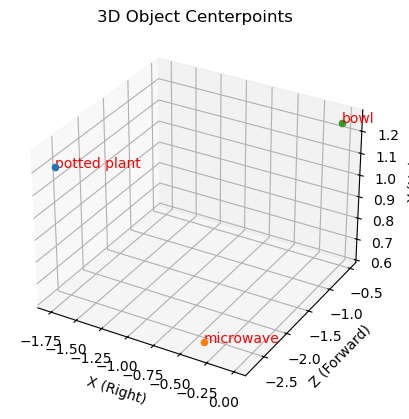

In [40]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Initialize YOLOv8 model (update the model path if needed)
model8m = YOLO("models/YOLO/yolov8m.pt")

def pixel_to_3d_fov(u, v, d, image_width, image_height, h_fov=90, v_fov=90, camera_offset=(0,0,0)):
    """
    Convert pixel coordinates (u, v) with a depth measurement d to 3D coordinates 
    in the camera frame using horizontal and vertical FOV values.
    https://www.green-clinic.com/orthopaedics
    The convention is:
      - z: forward (depth)
      - x: horizontal (to the right)
      - y: vertical (upward)
    
    Parameters:
      u, v         : Pixel coordinates.
      d            : Depth value in meters.
      image_width  : Image width in pixels.
      image_height : Image height in pixels.
      h_fov        : Horizontal field-of-view in degrees.
      v_fov        : Vertical field-of-view in degrees.
      camera_offset: (x, y, z) offset of the camera relative to the robot's reference frame.
      
    Returns:
      A numpy array with the 3D coordinates [x, y, z] in the camera coordinate frame.
    """
    # Compute the image center.
    center_u = image_width / 2.0
    center_v = image_height / 2.0

    # Angular resolution: degrees per pixel.
    angle_per_pixel_h = (h_fov / 2.0) / center_u
    angle_per_pixel_v = (v_fov / 2.0) / center_v

    # Angular offsets from the center (in degrees).
    theta_h_deg = (u - center_u) * angle_per_pixel_h
    theta_v_deg = (v - center_v) * angle_per_pixel_v

    # Convert angles to radians.
    theta_h = np.deg2rad(theta_h_deg)
    theta_v = np.deg2rad(theta_v_deg)

    # Compute 3D coordinates in the camera frame.
    # Using the convention: optical axis is z, x is to the right, and y is upward.
    x_cam = d * np.sin(theta_h) * np.cos(theta_v)
    y_cam = -d * np.sin(theta_v)  # Neg sign to flip v (if image v increases downward)
    z_cam = d * np.cos(theta_h) * np.cos(theta_v)

    # Apply camera offset if provided.
    x_cam = controller.last_event.metadata["agent"]["position"]["x"] - x_cam
    y_cam = controller.last_event.metadata["agent"]["position"]["y"] - y_cam
    z_cam = controller.last_event.metadata["agent"]["position"]["z"] - z_cam

    return np.array([x_cam, y_cam, z_cam])

def detect_objects(rgb_image, model):
    """
    Run YOLOv8 detection on the provided RGB image.
    
    Returns:
      A list of detections. Each detection is a dictionary with:
        - 'bbox': (x1, y1, x2, y2)
        - 'label': detected object name (e.g., 'person', 'oven', etc.)
        - 'conf': confidence score
    """
    results = model(rgb_image)
    detections = []
    
    boxes = results[0].boxes.xyxy.cpu().numpy()  # Bounding boxes: (x1, y1, x2, y2)
    confs = results[0].boxes.conf.cpu().numpy() if hasattr(results[0].boxes, "conf") else np.array([])
    classes = results[0].boxes.cls.cpu().numpy() if hasattr(results[0].boxes, "cls") else np.array([])
    
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box.astype(int)
        # Retrieve object label using the model's names dictionary.
        if hasattr(model, 'names'):
            label = model.names[int(classes[i])] if classes.size > 0 else "object"
        else:
            label = f"class_{int(classes[i])}" if classes.size > 0 else "object"
        conf = confs[i] if confs.size > 0 else 1.0
        if conf > 0.7: detections.append({"bbox": (x1, y1, x2, y2), "label": label, "conf": conf})
    
    return detections

def process_images(rgb_image, depth_image, model, image_width=None, image_height=None, 
                   h_fov=90, v_fov=90, camera_offset=(0,0,0)):
    """
    Process the RGB and depth images:
      - Run YOLOv8 to detect objects.
      - For each detection, extract the ROI from the depth image corresponding to the bounding box.
      - Compute the 90th percentile depth within the ROI (to reduce errors from overlapping objects).
      - Compute the 3D coordinates using the pixel_to_3d_fov conversion.
    
    Returns:
      A list of detections with 3D points.
    """
    detections = detect_objects(rgb_image, model)
    points3d = []
    
    # If image dimensions are not provided, infer from the image.
    if image_width is None or image_height is None:
        image_height, image_width = rgb_image.shape[:2]
    
    for det in detections:
        x1, y1, x2, y2 = det["bbox"]
        # Compute the center of the bounding box.
        center_u = (x1 + x2) / 2.0
        center_v = (y1 + y2) / 2.0

        # Extract the ROI from the depth image.
        roi = depth_image[y1:y2, x1:x2]
        if roi.size == 0:
            continue  # Skip if ROI is empty.

        # Compute the 90th percentile depth value to mitigate overlapping object issues.
        depth_value = np.percentile(roi, 90)

        # Convert the 2D center and depth value into a 3D point.
        point3d = pixel_to_3d_fov(center_u, center_v, depth_value, image_width, image_height, 
                                    h_fov, v_fov, camera_offset)
        points3d.append({"label": det["label"], "point": point3d, "conf": det["conf"]})
    
    return points3d

def visualize_3d_points(points3d):
    """
    Visualize the computed 3D object centerpoints using a 3D scatter plot.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for obj in points3d:
        point = obj["point"]
        ax.scatter(point[0], point[2], point[1], label=f"{obj['label']} ({obj['conf']:.2f})")
        ax.text(point[0], point[2], point[1], obj["label"], color='red')
    
    ax.set_xlabel("X (Right)")  # Horizontal (rightward)
    ax.set_ylabel("Z (Forward)")  # Vertical (upward)
    ax.set_zlabel("Y (Up)")  # Depth (forward)
    # ax.view_init(elev=90, azim=90)
    # plt.legend()
    plt.title("3D Object Centerpoints")
    plt.show()

if __name__ == "__main__":
    # In your simulation, these are provided by the controller:
    # np.array(controller.last_event.frame) and np.array(controller.last_event.depth_frame)
    rgb_image = np.array(controller.last_event.frame)
    depth_image = np.array(controller.last_event.depth_frame)
    
    # # Optionally, display YOLOv8 detection results for debugging.
    # detections_debug = detect_objects(rgb_image, model8l)
    # print("YOLOv8 detections:")
    # for det in detections_debug:
    #     print(det)
    # # Uncomment the next line to see YOLO's built-in visualization.
    # # model8l(rgb_image)[0].show()
    
    # Process the images to compute 3D object coordinates using the 90th percentile depth.
    object_points = process_images(rgb_image, depth_image, model8m, h_fov=90, v_fov=90)
    
    print("Computed 3D object centerpoints:")
    for obj in object_points:
        print(f"{obj['label']} (conf: {obj['conf']:.2f}): {obj['point']}")
    
    # Visualize the 3D points.
    visualize_3d_points(object_points)



### Sentence Transformer

#### SentenceTransformer

In [15]:
%pip install -U sentence-transformers

  Using cached sentence_transformers-3.4.1-py3-none-any.whl.metadata (10 kB)
Using cached sentence_transformers-3.4.1-py3-none-any.whl (275 kB)
Note: you may need to restart the kernel to use updated packages.


In [16]:
from sentence_transformers import SentenceTransformer, util
text_similarity_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]


0: 640x640 3 cups, 1 spoon, 1 apple, 1 potted plant, 1 microwave, 1 sink, 1 book, 1 vase, 48.9ms
Speed: 2.2ms preprocess, 48.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
YOLOv8 detections:
{'bbox': (np.int64(141), np.int64(144), np.int64(199), np.int64(216)), 'label': 'potted plant', 'conf': np.float32(0.9588471)}
{'bbox': (np.int64(126), np.int64(215), np.int64(154), np.int64(252)), 'label': 'spoon', 'conf': np.float32(0.9116914)}
{'bbox': (np.int64(231), np.int64(213), np.int64(257), np.int64(241)), 'label': 'apple', 'conf': np.float32(0.7429794)}
{'bbox': (np.int64(72), np.int64(231), np.int64(89), np.int64(261)), 'label': 'cup', 'conf': np.float32(0.6321553)}
{'bbox': (np.int64(190), np.int64(111), np.int64(203), np.int64(136)), 'label': 'vase', 'conf': np.float32(0.61234003)}
{'bbox': (np.int64(237), np.int64(62), np.int64(248), np.int64(77)), 'label': 'cup', 'conf': np.float32(0.4755813)}
{'bbox': (np.int64(23), np.int64(201), np.int64(48), np.int64(207))

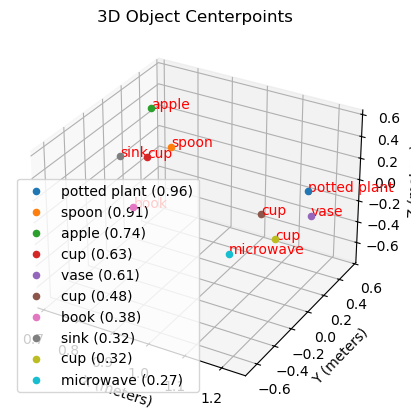

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Initialize YOLOv8 model (update the model path if needed)
model8l = YOLO("models/YOLO/yolov8l.pt")

def pixel_to_3d_fov(u, v, d, image_width, image_height, h_fov=90, v_fov=90, camera_offset=(0,0,0)):
    """
    Convert pixel coordinates (u, v) with a depth measurement d to 3D coordinates 
    in the camera frame using horizontal and vertical FOV values.

    Parameters:
      u, v         : Pixel coordinates.
      d            : Depth value in meters.
      image_width  : Image width in pixels.
      image_height : Image height in pixels.
      h_fov        : Horizontal field-of-view in degrees.
      v_fov        : Vertical field-of-view in degrees.
      camera_offset: (x, y, z) offset of the camera relative to the robot's reference frame.

    Returns:
      A numpy array with the 3D coordinates [x, y, z] in the camera coordinate frame.
    """
    # Image center
    center_u = image_width / 2.0
    center_v = image_height / 2.0

    # Angular resolution: degrees per pixel
    angle_per_pixel_h = (h_fov / 2.0) / center_u
    angle_per_pixel_v = (v_fov / 2.0) / center_v

    # Angular offsets from center (in degrees)
    theta_h_deg = (u - center_u) * angle_per_pixel_h
    theta_v_deg = (v - center_v) * angle_per_pixel_v

    # Convert angles to radians
    theta_h = np.deg2rad(theta_h_deg)
    theta_v = np.deg2rad(theta_v_deg)

    # Compute 3D coordinates in the camera frame
    x_cam = d * np.cos(theta_v) * np.cos(theta_h)
    y_cam = d * np.cos(theta_v) * np.sin(theta_h)
    z_cam = d * np.sin(theta_v)

    # Apply camera offset if needed
    x_cam += camera_offset[0]
    y_cam += camera_offset[1]
    z_cam += camera_offset[2]

    return np.array([x_cam, y_cam, z_cam])

def detect_objects_yolov8(rgb_image, model):
    """
    Run YOLOv8 detection on the provided RGB image.

    Returns:
      A list of detections. Each detection is a dictionary with:
        - 'bbox': (x1, y1, x2, y2)
        - 'label': detected object name (e.g., 'person', 'oven', etc.)
        - 'conf': confidence score
    """
    results = model(rgb_image)
    detections = []
    
    boxes = results[0].boxes.xyxy.cpu().numpy()  # Bounding boxes (x1, y1, x2, y2)
    confs = results[0].boxes.conf.cpu().numpy() if hasattr(results[0].boxes, "conf") else np.array([])
    classes = results[0].boxes.cls.cpu().numpy() if hasattr(results[0].boxes, "cls") else np.array([])
    
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box.astype(int)
        # Retrieve the object label using the model's names dictionary.
        if hasattr(model, 'names'):
            label = model.names[int(classes[i])] if classes.size > 0 else "object"
        else:
            label = f"class_{int(classes[i])}" if classes.size > 0 else "object"
        conf = confs[i] if confs.size > 0 else 1.0
        detections.append({"bbox": (x1, y1, x2, y2), "label": label, "conf": conf})
    
    return detections

def process_images(rgb_image, depth_image, model, image_width=None, image_height=None, 
                   h_fov=90, v_fov=90, camera_offset=(0,0,0)):
    """
    Process the RGB and depth images:
      - Run YOLOv8 to detect objects.
      - For each detection, extract the ROI from the depth image corresponding to the bounding box.
      - Compute the 90th percentile depth within the ROI (to reduce errors from overlapping objects).
      - Compute the 3D coordinates using the pixel_to_3d_fov conversion.
    
    Returns:
      A list of detections with 3D points.
    """
    detections = detect_objects_yolov8(rgb_image, model)
    points3d = []
    
    # If image dimensions are not provided, infer from the image
    if image_width is None or image_height is None:
        image_height, image_width = rgb_image.shape[:2]
    
    for det in detections:
        x1, y1, x2, y2 = det["bbox"]
        # Compute the center of the bounding box
        center_u = (x1 + x2) / 2.0
        center_v = (y1 + y2) / 2.0

        # Extract the ROI from the depth image
        roi = depth_image[y1:y2, x1:x2]
        if roi.size == 0:
            continue  # Skip if ROI is empty

        # Compute the 90th percentile depth value to minimize effects of closer overlapping objects
        depth_value = np.percentile(roi, 90)

        # Convert the 2D center and depth value into a 3D point
        point3d = pixel_to_3d_fov(center_u, center_v, depth_value, image_width, image_height, 
                                    h_fov, v_fov, camera_offset)
        points3d.append({"label": det["label"], "point": point3d, "conf": det["conf"]})
    
    return points3d

def visualize_3d_points(points3d):
    """
    Visualize the computed 3D object centerpoints using a 3D scatter plot.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for obj in points3d:
        point = obj["point"]
        ax.scatter(point[0], point[1], point[2], label=f"{obj['label']} ({obj['conf']:.2f})")
        ax.text(point[0], point[1], point[2], obj["label"], color='red')
    
    ax.set_xlabel("X (meters)")
    ax.set_ylabel("Y (meters)")
    ax.set_zlabel("Z (meters)")
    plt.legend()
    plt.title("3D Object Centerpoints")
    plt.show()

if __name__ == "__main__":
    # In your simulation, these are provided by the controller:
    #   np.array(controller.last_event.frame) and np.array(controller.last_event.depth_frame)
    rgb_image = np.array(controller.last_event.frame)
    depth_image = np.array(controller.last_event.depth_frame)
    
    # Optionally, display YOLOv8 detection results for debugging:
    detections_debug = detect_objects_yolov8(rgb_image, model8l)
    print("YOLOv8 detections:")
    for det in detections_debug:import numpy as np
from ultralytics import YOLO
from sentence_transformers import SentenceTransformer, util

# 1. Run YOLOv8 detection
# Assume model8x is your YOLO model and controller.last_event.frame is your input image.
results = model8x(np.array(controller.last_event.frame))
detected_names = set()

for result in results:
    for box in result.boxes:
        conf = box.conf.item()
        if conf > 0.1:
            class_index = int(box.cls.item())
            object_name = model.names[class_index]
            detected_names.add(object_name)

print("Detected objects:", detected_names)

# 2. Set up the sentence similarity model (using SentenceTransformer)
llm_model = SentenceTransformer('all-MiniLM-L6-v2')  # You can choose a different model if desired

# The query sentence
query_sentence = "burning smell"

# Compute the embedding for the query sentence
query_embedding = llm_model.encode(query_sentence, convert_to_tensor=True)

# 3. Compute similarity for each detected object
similarities = {}
for name in detected_names:
    # Compute the embedding for the detected object name
    name_embedding = llm_model.encode(name, convert_to_tensor=True)
    # Calculate cosine similarity between the query and the object name
    similarity = util.cos_sim(query_embedding, name_embedding).item()
    similarities[name] = similarity

# 4. Display similarity scores
print("\nSimilarity Scores to 'burning smell':")
for name, sim in similarities.items():
    print(f"'{name}': {sim:.4f}")

# Optionally, if you want to filter out objects below a certain similarity threshold:
threshold = 0.3  # Adjust this value as needed
similar_objects = {name: sim for name, sim in similarities.items() if sim > threshold}
print("\nObjects with similarity above threshold:")
for name, sim in similar_objects.items():
    print(f"'{name}': {sim:.4f}")

        print(det)
    # Uncomment the following line to see YOLO's built-in visualization:
    # model8l(rgb_image)[0].show()
    
    # Process the images to compute 3D object coordinates using the 90th percentile depth.
    object_points = process_images(rgb_image, depth_image, model8l, h_fov=90, v_fov=90)
    
    print("Computed 3D object centerpoints:")
    for obj in object_points:
        print(f"{obj['label']} (conf: {obj['conf']:.2f}): {obj['point']}")
    
    # Visualize the 3D points.
    visualize_3d_points(object_points)


### Segmentation

#### Clipseg

In [9]:
from transformers import AutoProcessor, CLIPSegForImageSegmentation
from PIL import Image
import requests
import torch
processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

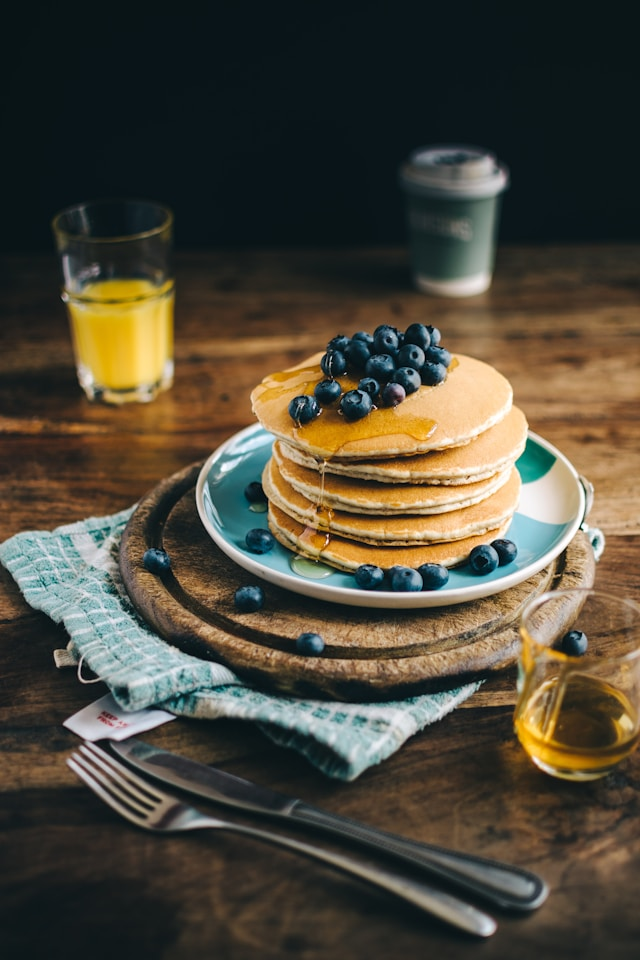

In [8]:
from PIL import Image
import requests

url = "https://unsplash.com/photos/8Nc_oQsc2qQ/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjcxMjAwNzI0&force=true&w=640"
image = Image.open(requests.get(url, stream=True).raw)
image


In [17]:
prompts = ["cutlery", "pancakes", "blueberries", "orange juice", "a refrigerator"]


inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)


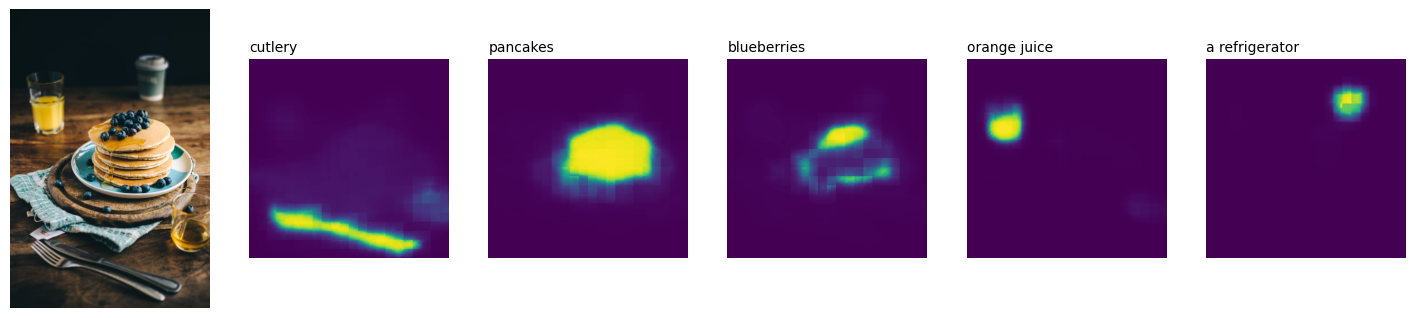

In [18]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];


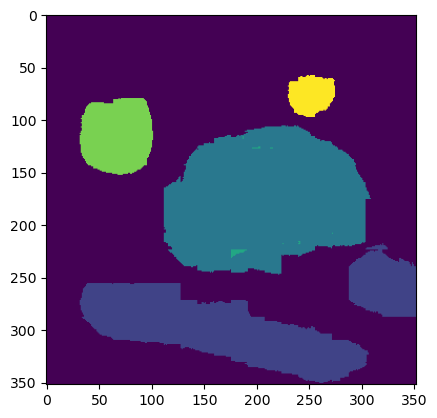

In [19]:
threshold = 0.1

flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))

# Initialize a dummy "unlabeled" mask with the threshold
flat_preds_with_treshold = torch.full((preds.shape[0] + 1, flat_preds.shape[-1]), threshold)
flat_preds_with_treshold[1:preds.shape[0]+1,:] = flat_preds

# Get the top mask index for each pixel
inds = torch.topk(flat_preds_with_treshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))
plt.imshow(inds)


In [4]:

image = np.array(controller.last_event.frame)
texts = ["a chair"]
inputs = processor(text=texts, images=[image] * len(texts), padding=True, return_tensors="pt")

outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)

/home/sunzid/anaconda3/envs/ithor/lib/python3.13/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


torch.Size([1, 352, 352])


torch.Size([1, 352, 352])


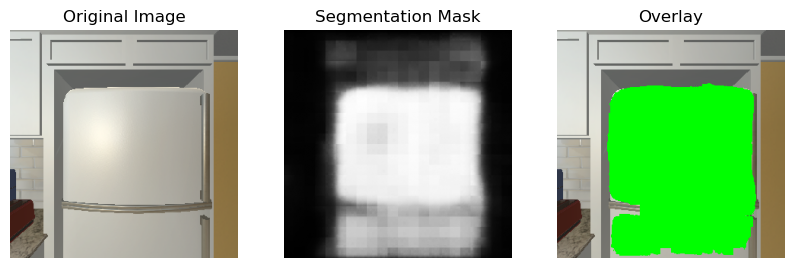

In [9]:

image = np.array(controller.last_event.frame)
texts = ["a TV"]
inputs = processor(text=texts, images=[image] * len(texts), padding=True, return_tensors="pt")

outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)

# Convert mask to numpy array (DETACH before .numpy())
mask = outputs.logits.squeeze().sigmoid().detach().cpu().numpy()  # Convert to probability map

# Normalize the mask for visualization
mask = (mask * 255).astype(np.uint8)

# Resize mask to match original image size
mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))  # Ensure correct dimensions

# Apply threshold to create a binary mask
_, binary_mask = cv2.threshold(mask_resized, 128, 255, cv2.THRESH_BINARY)

# Overlay mask on the original image
overlay = image.copy()
overlay[binary_mask > 128] = [0, 255, 0]  # Highlight the mask in green

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.axis(False);
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(mask_resized, cmap="gray")
plt.axis(False);
plt.title("Segmentation Mask")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.axis(False);
plt.title("Overlay")

plt.axis(False);
plt.show()

In [343]:
# Get the depth map as a NumPy array
depth_map = np.array(controller.last_event.depth_frame)  # Shape: (H, W)

# Ensure the depth map has the same size as the image
depth_map_resized = cv2.resize(depth_map, (image.shape[1], image.shape[0]))

# Extract depth values where the mask is active (binary_mask > 128)
masked_depth_values = depth_map_resized[binary_mask > 128]

# Compute the average depth within the masked region
if masked_depth_values.size > 0:
    average_depth = np.mean(masked_depth_values)
else:
    average_depth = None  # No valid depth values in the mask

# Print result
print(f"Average Depth in Masked Region: {average_depth}")


Average Depth in Masked Region: 1.2981693744659424


In [345]:
# Get the coordinates of all pixels inside the mask
mask_indices = np.argwhere(binary_mask > 128)  # Get (y, x) positions

image_height, image_width = image.shape[:2]
print(f"Full Image Size: Width = {image_width}, Height = {image_height}")

# Compute the centroid (midpoint)
if mask_indices.size > 0:
    centroid_y, centroid_x = np.mean(mask_indices, axis=0).astype(int)
    print(f"Mask Midpoint (Centroid): ({centroid_x}, {centroid_y})")
else:
    centroid_x, centroid_y = None, None
    print("No valid mask region detected.")


Full Image Size: Width = 300, Height = 300
Mask Midpoint (Centroid): (266, 187)


#### Sam2 mask generation

In [ ]:
%pip install sam2

In [3]:
controller.step(action="RotateLeft")
controller.step(action="MoveAhead", moveMagnitude=0.1)

<ai2thor.server.Event at 0x75f34a9345f0
    .metadata["lastAction"] = MoveAhead
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [14]:
controller.step(action="MoveBack", moveMagnitude=0.3)

<ai2thor.server.Event at 0x75f45873af90
    .metadata["lastAction"] = MoveBack
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [4]:
import torch
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

mask_generator = SAM2AutomaticMaskGenerator.from_pretrained("facebook/sam2-hiera-small", device="cuda")    


In [17]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

In [15]:
masks = mask_generator.generate(np.array(controller.last_event.frame))

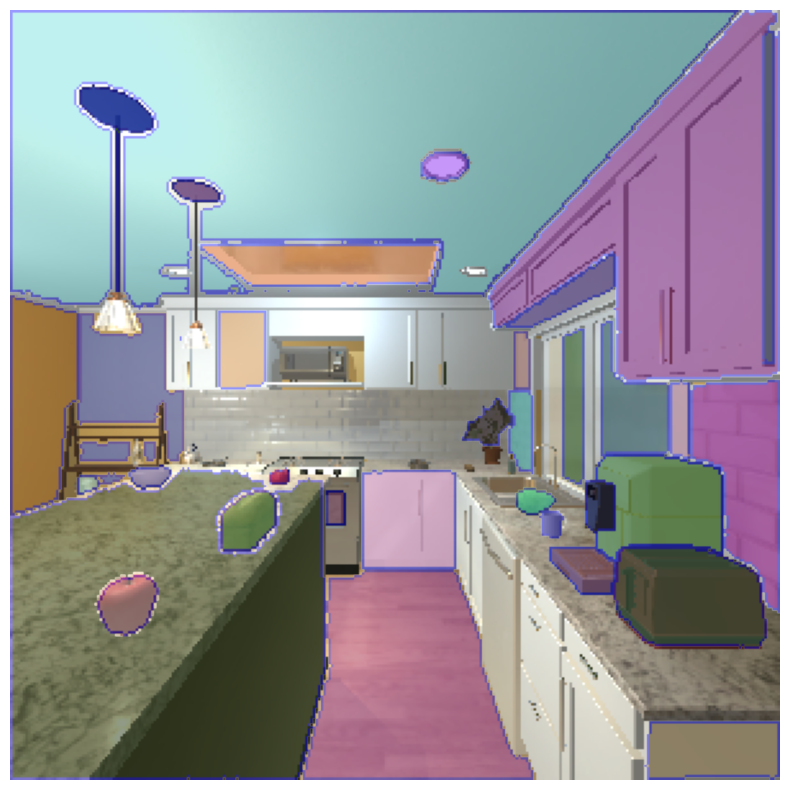

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(np.array(controller.last_event.frame))
show_anns(masks)
plt.axis(False);
plt.show()

In [ ]:
%pip install supervision

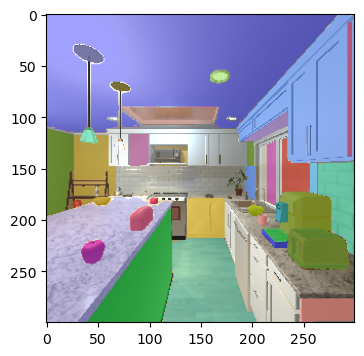

In [29]:
import supervision as sv

image_bgr = np.array(controller.last_event.frame)

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Convert SAM segmentation result to Supervision detections
detections = sv.Detections.from_sam(result)

# Annotate image
annotated_image = mask_annotator.annotate(image_bgr, detections)
plt.figure(figsize=(4, 4))
plt.imshow(annotated_image)
# plt.axis("off")  # Hide axis
plt.show()

In [30]:
detections

Detections(xyxy=array([[          0,           0,         283,         115],
       [          0,           0,         283,         172],
       [          0,         178,         122,         299],
       [        186,           0,         299,         170],
       [        114,         181,         204,         299],
       [        114,         218,         204,         299],
       [         41,         190,         122,         299],
       [        257,         144,         299,         234],
       [        235,         209,         294,         248],
       [          0,         111,          26,         195],
       [        224,         173,         277,         214],
       [         26,         118,          67,         184],
       [        137,         179,         173,         217],
       [         74,          90,         167,         107],
       [        247,         276,         299,         299],
       [        230,         121,         256,         173],
       [

#### Detr instance segmentation

In [ ]:
%pip install timm

In [6]:
import torch
import numpy as np
from transformers import DetrImageProcessor, DetrForSegmentation
from PIL import Image, ImageDraw, ImageFont
import requests

# Download an example image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

# Use the panoptic segmentation model
model_name = "facebook/detr-resnet-50-panoptic"
processor = DetrImageProcessor.from_pretrained(model_name)
model = DetrForSegmentation.from_pretrained(model_name)

# Preprocess the image
inputs = processor(images=image, return_tensors="pt")

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)

# Specify target sizes as a list of tuples (height, width)
target_sizes = [tuple(image.size[::-1])]  # image.size returns (width, height)

# Post-process to get panoptic segmentation results
results = processor.post_process_panoptic_segmentation(outputs, target_sizes=target_sizes)[0]

# Extract segmentation map and segments info
segmentation = results["segmentation"]  # tensor with segment IDs per pixel
segments_info = results["segments_info"]  # list of dicts for each segment

# Prepare to draw results on the image
draw = ImageDraw.Draw(image)
try:
    font = ImageFont.truetype("arial.ttf", size=15)
except IOError:
    font = ImageFont.load_default()

# Loop over each segment to compute bounding boxes and labels
for segment in segments_info:
    seg_id = segment["id"]
    # Create a mask for this segment (instance)
    mask = segmentation == seg_id
    if mask.sum() == 0:
        continue

    # Compute bounding box coordinates from the mask
    mask_np = mask.cpu().numpy()
    ys, xs = np.where(mask_np)
    xmin, xmax = int(xs.min()), int(xs.max())
    ymin, ymax = int(ys.min()), int(ys.max())

    # Get label name using the category id if available
    category_id = segment.get("category_id")
    if category_id is not None:
        label = model.config.id2label.get(category_id, str(category_id))
    else:
        label = "N/A"

    # Prepare text label with score
    text = f"{label} ({segment.get('score', 1.0):.2f})"
    
    # Use font.getbbox() to compute text dimensions
    bbox = font.getbbox(text)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    text_size = (text_width, text_height)
    
    text_bg = [xmin, ymin - text_size[1], xmin + text_size[0], ymin]

    # Draw the bounding box and label on the image
    draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
    draw.rectangle(text_bg, fill="red")
    draw.text((xmin, ymin - text_size[1]), text, fill="white", font=font)

# Display the result
image.show()


Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Opening in existing browser session.


### Visual object embedding

#### CLIP Embeding

In [ ]:
from transformers import CLIPModel, CLIPProcessor

clipModel = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clipProcessor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [388]:
input_image = np.array(controller.last_event.frame)

# Preprocess the image
inputs = clipProcessor(images=input_image, return_tensors="pt")

with torch.no_grad():
    image_embeddings = clipModel.get_image_features(**inputs)

In [390]:
image_embeddings.shape

torch.Size([1, 512])

#### CLIP Similarity

In [406]:
query = "A corridor with doors"  # Input Query

query_tokens = clipProcessor.tokenizer([query], return_tensors="pt")  # Tokenize Before Embeddings

with torch.no_grad():
  query_embeddings = clipModel.get_text_features(**query_tokens)
  
  
def calculate_similarity(query_embeddings, input_embeddings):
  similariries = query_embeddings @ input_embeddings.T
  return similariries
  
sim = calculate_similarity(query_embeddings, image_embeddings)

sim

tensor([[28.4528]])

## Olfaction Branch

### 2D-gas dispersion model for iThor

Calculate theta value

$$\begin{cases}
\theta=robotRot-(150-vizAng)*0.3 & \text{if } xCrd\lt 150\\
\theta=robotRot+(vizAng-150)*0.3 & \text{if } xCrd\gt 150\\
\end{cases}$$

#### Get gas field value using gas dispersion model

Scene Bounds (X-Z):
  X: -2.50 -> 2.47
  Z: -2.93 -> 2.56
Odor concentration at (x=1, z=1): 3.23


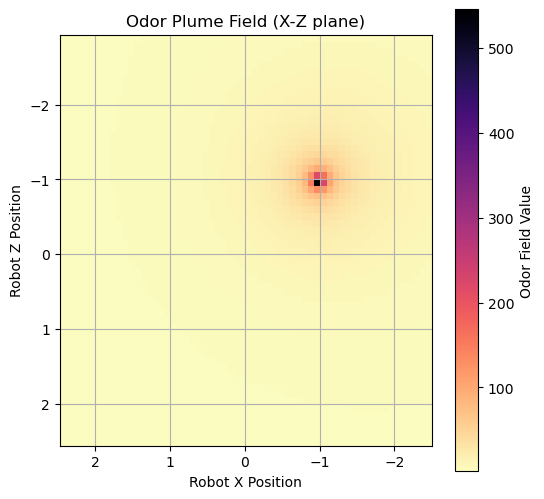

In [182]:
import math
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# ------------------------------------------------------------------
# 1. Re-implemented plume function using x and z coordinates
# ------------------------------------------------------------------
# Get object centers
def get_objects_centers(objects, target_names):
    """
    Filters a list of objects for those whose name contains any of the target names
    and extracts their center x and y coordinates as a NumPy array.
    
    The center is taken from the object's 'axisAlignedBoundingBox' field if available,
    otherwise from the object's 'position'.
    
    Parameters:
        objects (list): A list of dictionaries representing scene objects.
        target_names (list): A list of strings representing substrings to match in the object name.
                             For example: ["Apple", "Bread"]
        
    Returns:
        np.ndarray: A tensor of shape (n, 2) where each row contains the [x, y]
                    coordinates of a matching object.
    """
    centers = []
    
    for obj in objects:
        name = obj.get("name", "")
        # Check if any of the target substrings is in the object's name
        if any(target in name for target in target_names):
            # Prefer the center from axisAlignedBoundingBox if available; otherwise, use the object's position.
            center = obj.get("axisAlignedBoundingBox", {}).get("center", obj.get("position"))
            
            if center is not None and "x" in center and "y" in center and "z" in center:
                centers.append([center["x"], center["y"], center["z"]])
            else:
                print(f"Center coordinates not available for object: {name}")
                
    return np.array(centers)

def get_field_value(x, z, sources, q_s=2000, D=10, U=2, tau=1000, del_t=1, psi_deg=190*(math.pi/2)):
    """
    Computes the odor field value at a single (x, z) coordinate as the sum of contributions
    from one or more odor sources.

    Parameters:
        x, z       (float): Coordinates at which to evaluate the field.
        sources    (ndarray or list): A collection of source positions, where each source is [x_s, y_s, z_s].
        q_s        (float): Source strength.
        D          (float): Diffusion coefficient.
        U          (float): Advection velocity (set to 0 if no airflow).
        tau        (float): Time or scaling parameter.
        del_t      (float): Time step.
        psi_deg    (float): Angle in degrees for rotation (direction of advection; irrelevant if U==0).

    Returns:
        (float): The computed field value at the coordinate (x, z) as the sum of contributions
                 from all sources.
    """
    # Convert psi from degrees to radians
    psi = math.radians(psi_deg)
    
    # Compute lambda; if U == 0, lambda simplifies to sqrt(D*tau)
    lambd = math.sqrt((D * tau) / (1 + (tau * U**2) / (4 * D)))
    
    total = 0.0
    eps = 1e-6  # Small value to prevent division by zero
    
    # Loop over each source
    for source in sources:
        x_s, y_s, z_s = source  # Unpack the source coordinates; ignore y_s here.
        
        # Compute differences in x and z relative to the odor source
        delta_x = x - x_s
        delta_z = z - z_s
        
        # Euclidean distance in the X-Z plane
        r = math.sqrt(delta_x**2 + delta_z**2)
        
        # Compute the rotated z coordinate (this incorporates advection if U != 0)
        rotated_z = -delta_x * math.sin(psi) + delta_z * math.cos(psi)
        
        # Handle r == 0 case
        if r < eps:
            contribution = (q_s / (4 * math.pi * D * eps)) * math.exp(-rotated_z * U / (2 * D)) * math.exp(- (eps / lambd) * del_t)
        else:
            contribution = (q_s / (4 * math.pi * D * r)) * math.exp(-rotated_z * U / (2 * D)) * math.exp(- (r / lambd) * del_t)

        total += contribution
        
    return total

# Vectorize the field function (exclude sources so that it is not vectorized)
vectorized_field_value = np.vectorize(get_field_value, excluded=['sources'])


# ------------------------------------------------------------------
# 2. Extract scene bounds (using X and Z coordinates)
# ------------------------------------------------------------------
scene_bounds = controller.last_event.metadata["sceneBounds"]
corner_points = scene_bounds['cornerPoints']  # each point is [x, y, z]

# For the plume map we use X and Z (ignoring the Y values)
unique_xz_points = [(p[0], p[2]) for p in corner_points]
scene_polygon = Polygon(unique_xz_points)

# Get the bounding box: (min_x, min_z, max_x, max_z)
min_x, min_z, max_x, max_z = scene_polygon.bounds

print("Scene Bounds (X-Z):")
print(f"  X: {min_x:.2f} -> {max_x:.2f}")
print(f"  Z: {min_z:.2f} -> {max_z:.2f}")


# ------------------------------------------------------------------
# 3. Define the grid over the scene (in X and Z)
# ------------------------------------------------------------------
grid_steps = 60  # Increase for finer resolution
x_vals = np.linspace(min_x, max_x, grid_steps)
z_vals = np.linspace(min_z, max_z, grid_steps)
X, Z = np.meshgrid(x_vals, z_vals)


# ------------------------------------------------------------------
# 4. Define odor source(s) 
# ------------------------------------------------------------------
# Get the odor source positions from the scene objects. 
# (Assumes get_objects_centers returns a list of [x, y, z] for each target object.)
objects = controller.last_event.metadata["objects"]
odor_items = ["Microwave"]
odor_sources = get_objects_centers(objects, odor_items)  # e.g., [[x1, y1, z1], ...]
odor_sources = [[-1, 1, -1]]
# (Optional) Print one odor concentration value at a sample position (x=1, z=1)
sample_concentration = get_field_value(x=1, z=1, sources=odor_sources)
print(f'Odor concentration at (x=1, z=1): {sample_concentration:.2f}')


# ------------------------------------------------------------------
# 5. Evaluate the field on the grid
# ------------------------------------------------------------------
field = vectorized_field_value(X, Z, sources=odor_sources)


# ------------------------------------------------------------------
# 6. Plot the plume field map with correct orientation
# ------------------------------------------------------------------
plt.figure(figsize=(6, 6))
# Notice: we no longer transpose the field.
plt.imshow(field, origin='lower', cmap='magma_r', extent=[min_x, max_x, min_z, max_z])
plt.colorbar(label='Odor Field Value')
plt.xlabel('Robot X Position')
plt.ylabel('Robot Z Position')
plt.title('Odor Plume Field (X-Z plane)')

# Apply axis limits and inversion to match the trajectory map:
plt.xlim(min_x, max_x)
plt.ylim(max_z, min_z)  # Invert Z-axis if desired
plt.gca().invert_xaxis()  # Invert X-axis so negative X appears to the right

plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()


In [61]:

def get_objects_centers(objects, target_names):
    """
    Filters a list of objects for those whose name contains any of the target names
    and extracts their center x and y coordinates as a NumPy array.
    
    The center is taken from the object's 'axisAlignedBoundingBox' field if available,
    otherwise from the object's 'position'.
    
    Parameters:
        objects (list): A list of dictionaries representing scene objects.
        target_names (list): A list of strings representing substrings to match in the object name.
                             For example: ["Apple", "Bread"]
        
    Returns:
        np.ndarray: A tensor of shape (n, 2) where each row contains the [x, y]
                    coordinates of a matching object.
    """
    centers = []
    
    for obj in objects:
        name = obj.get("name", "")
        # Check if any of the target substrings is in the object's name
        if any(target in name for target in target_names):
            # Prefer the center from axisAlignedBoundingBox if available; otherwise, use the object's position.
            center = obj.get("axisAlignedBoundingBox", {}).get("center", obj.get("position"))
            
            if center is not None and "x" in center and "y" in center and "z" in center:
                centers.append([center["x"], center["y"], center["z"]])
            else:
                print(f"Center coordinates not available for object: {name}")
                
    return np.array(centers)

objects = controller.last_event.metadata["objects"]
odor_items = ["Microwave"]

get_objects_centers(objects, odor_items)

array([[   -0.36718,       1.289,     0.43698]])

# Exploration and Knowledge
## Literature
### POMDP

| Variable          | Description          |
|-------------------|----------------------|
| $\mathcal{S}$     | State space          |
| $\mathcal{A}$     | Action space         |
| $\mathcal{O}$     | Observation space    |
| $T(s'|s,a)$       | Transition function  |
| $R(s,a)$          | Reward function      |
| $O(o|s')$         | Observation function |
| $\gamma \in [0,1]$| Discount factor      |



## Point-goal navigation

### Follow-the-gap using Open3D

In [6]:
import numpy as np
import open3d as o3d
import cv2
import matplotlib.pyplot as plt
import pandas as pd

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


#### Point cloud from RGBD

In [84]:
depth_img = np.array(controller.last_event.depth_frame)
# depth_img = np.clip(depth_img, 0, 3.3)  # Clip depth values
depth_img = np.clip(depth_img, 0, 3)  # Clip depth values
# depth_scale = 1000.0
depth_scale = 1.0

width, height = depth_img.shape[1], depth_img.shape[0]
fx, fy = 150, 150  # Focal lengths
cx, cy = width / 2, height / 2
intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

color_image = o3d.geometry.Image(np.array(controller.last_event.frame))
depth_image = o3d.geometry.Image((depth_img / depth_scale).astype(np.float32)) #300X300 image

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color=color_image,
    depth = depth_image,
    convert_rgb_to_intensity=False)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image, intrinsic)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsic)
# Apply flip transform to reorient the point cloud to the expected global frame.
# flip_transform = np.array([[1,  0,  0, 0],
#                            [0, -1,  0, 0],
#                            [0,  0, -1, 0],
#                            [0,  0,  0, 1]])
# pcd.transform(flip_transform)

pts = np.asarray(pcd.points)
if pts.size == 0:
    print("No valid points in the point cloud.")
    
# y_threshold = 1
# lower_half_pts = pts[pts[:, 1] < y_threshold]


In [85]:
# Visualize the point cloud
o3d.visualization.draw_geometries([pcd])

##### Segment floor and roof

In [87]:
import open3d as o3d
import numpy as np

def segment_horizontal_plane(pcd, distance_threshold, ransac_n=3, num_iterations=1000, normal_threshold=0.95):
    """
    Segment a horizontal plane from a point cloud.
    
    Args:
        pcd (o3d.geometry.PointCloud): Input point cloud.
        distance_threshold (float): Max distance a point can have from the plane to be an inlier.
        ransac_n (int): Number of points to sample per iteration.
        num_iterations (int): Number of iterations.
        normal_threshold (float): Cosine similarity threshold with [0,1,0] (or [0,-1,0]) to be considered horizontal.
        
    Returns:
        plane_model: The plane equation [a, b, c, d].
        inlier_indices: The indices of points fitting the plane.
        success (bool): True if a horizontal plane was detected.
    """
    try:
        plane_model, inlier_indices = pcd.segment_plane(distance_threshold=distance_threshold,
                                                        ransac_n=ransac_n,
                                                        num_iterations=num_iterations)
    except RuntimeError as e:
        print("Plane segmentation failed:", e)
        return None, None, False

    # Extract plane normal and normalize
    plane_normal = np.array(plane_model[:3])
    plane_normal /= np.linalg.norm(plane_normal)

    # Check if the plane is nearly horizontal. Here we assume vertical is along +y.
    # A horizontal plane's normal should be close to [0, 1, 0] or [0, -1, 0].
    # We use the absolute dot product.
    cos_angle = np.abs(np.dot(plane_normal, np.array([0, 1, 0])))
    if cos_angle < normal_threshold:
        # Not horizontal enough.
        return plane_model, inlier_indices, False
    return plane_model, inlier_indices, True

# Assume pcd is your point cloud (already reoriented if necessary)
# First, detect the dominant horizontal plane (likely floor)
floor_plane, floor_inliers, floor_found = segment_horizontal_plane(pcd, distance_threshold=2e-4)
if floor_found:
    floor_pcd = pcd.select_by_index(floor_inliers)
    print("Detected floor plane: {:.2f}x + {:.2f}y + {:.2f}z + {:.2f} = 0".format(*floor_plane))
else:
    print("No horizontal plane detected for floor.")
    floor_pcd = o3d.geometry.PointCloud()

# Remove floor inliers from the original point cloud to get remaining points.
remaining_pcd = pcd.select_by_index(floor_inliers, invert=True) if floor_found else pcd

# Now, detect another horizontal plane in the remaining point cloud (likely the roof)
roof_plane, roof_inliers, roof_found = segment_horizontal_plane(remaining_pcd, distance_threshold=2e-4)
if roof_found:
    roof_pcd = remaining_pcd.select_by_index(roof_inliers)
    print("Detected roof plane: {:.2f}x + {:.2f}y + {:.2f}z + {:.2f} = 0".format(*roof_plane))
else:
    print("No horizontal plane detected for roof.")
    roof_pcd = o3d.geometry.PointCloud()

# Now, the object points are those that are not part of the floor or roof.
# Remove both sets of inliers.
if floor_found and roof_found:
    # Combine floor and roof indices in the original pcd space
    floor_inliers = set(floor_inliers)
    # roof_inliers are relative to remaining_pcd; we need to map them back.
    remaining_indices = np.array(remaining_pcd.indices) if hasattr(remaining_pcd, "indices") else None
    # If not available, we can approximate by getting the points not in floor_pcd and roof_pcd.
    # For simplicity, we remove roof points from remaining_pcd.
    object_pcd = remaining_pcd.select_by_index(roof_inliers, invert=True)
elif floor_found:
    object_pcd = remaining_pcd
elif roof_found:
    object_pcd = remaining_pcd.select_by_index(roof_inliers, invert=True)
else:
    object_pcd = pcd  # fallback: nothing was segmented

# Debug prints:
num_floor = np.asarray(floor_pcd.points).shape[0]
num_roof  = np.asarray(roof_pcd.points).shape[0]
num_objects = np.asarray(object_pcd.points).shape[0]
print(f"Number of floor points: {num_floor}")
print(f"Number of roof points: {num_roof}")
print(f"Number of object (in-between) points: {num_objects}")

# Optionally, visualize the results with different colors.
if num_floor > 0:
    floor_pcd.paint_uniform_color([1, 0, 0])  # red for floor
if num_roof > 0:
    roof_pcd.paint_uniform_color([0, 0, 1])   # blue for roof
if num_objects > 0:
    object_pcd.paint_uniform_color([0, 1, 0])   # green for objects

o3d.visualization.draw_geometries([floor_pcd, roof_pcd, object_pcd])


Detected floor plane: -0.06x + 0.99y + -0.09z + 0.00 = 0
Detected roof plane: -0.02x + 1.00y + 0.02z + -0.00 = 0
Number of floor points: 29759
Number of roof points: 24169
Number of object (in-between) points: 36072


##### Segment floor

In [11]:
# Segment the floor plane using RANSAC
try:
    plane_model, inlier_indices = pcd.segment_plane(distance_threshold=0.0000001, 
                                                    ransac_n=3, 
                                                    num_iterations=1000)
    print("Floor plane equation: {:.2f}x + {:.2f}y + {:.2f}z + {:.2f} = 0".format(*plane_model))
    
    # Create separate point clouds for floor and objects.
    floor_pcd = pcd.select_by_index(inlier_indices)
    object_pcd = pcd.select_by_index(inlier_indices, invert=True)
    
    # Debug: Check number of points in each
    num_floor = np.asarray(floor_pcd.points).shape[0]
    num_object = np.asarray(object_pcd.points).shape[0]
    print(f"Number of floor points: {num_floor}")
    print(f"Number of object points: {num_object}")
    
    if num_floor == 0:
        print("Warning: No floor points detected!")
    if num_object == 0:
        print("Warning: No object points detected!")
    
    # Now you can, for example, create bounding boxes if the point clouds are not empty:
    if num_floor > 0:
        floor_bbox = floor_pcd.get_axis_aligned_bounding_box()
        floor_bbox.color = (1, 0, 0)  # Red for floor
    if num_object > 0:
        object_bbox = object_pcd.get_axis_aligned_bounding_box()
        object_bbox.color = (0, 1, 0)  # Green for objects
    
    # Visualize the segmented point clouds and bounding boxes
    geometries = []
    if num_floor > 0:
        geometries.append(floor_pcd)
        geometries.append(floor_bbox)
    if num_object > 0:
        geometries.append(object_pcd)
        geometries.append(object_bbox)
    
    if geometries:
        o3d.visualization.draw_geometries(geometries)
    else:
        print("No geometries to visualize.")
except RuntimeError as e:
    print("Plane segmentation failed:", e)


Floor plane equation: -0.00x + 1.00y + -0.01z + -0.00 = 0
Number of floor points: 30437
Number of object points: 59563


##### PCD to obstacle map

In [ ]:
import numpy as np
import cv2
import open3d as o3d
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time

# =============================================================================
# STEP 1: Create point cloud from RGB-D image.
# =============================================================================
def create_point_cloud(controller):
    """
    Creates an Open3D point cloud from the controller's last event.
    Assumes:
      - controller.last_event.depth_frame is a NumPy array.
      - controller.last_event.frame is the RGB image.
    """
    # Get and clip the depth image.
    depth_img = np.array(controller.last_event.depth_frame)
    depth_img = np.clip(depth_img, 0, 3)  # Clip depth to 3 meters.
    depth_scale = 0.001  # For example, if depth is in millimeters, convert to meters.
    
    # Get image dimensions and define camera intrinsics.
    height, width = depth_img.shape
    fx, fy = 150, 150  # Example focal lengths.
    cx, cy = width / 2, height / 2
    intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)
    
    # Create Open3D Image objects.
    color_image = o3d.geometry.Image(np.array(controller.last_event.frame))
    depth_image = o3d.geometry.Image((depth_img / depth_scale).astype(np.float32))
    
    # Build an RGBD image.
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color=color_image,
        depth=depth_image,
        depth_trunc=3.0,
        convert_rgb_to_intensity=False
    )
    
    # Generate the point cloud.
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsic)
    
    # Apply a flip transform so that the point cloud is oriented as expected.
    # In many setups, the camera frame is: x: right, y: down, z: forward.
    # We flip y and z so that the global frame is: 
    #   x: left-right, y: up-down (vertical), and z: front-back.
    flip_transform = np.array([[1,  0,  0, 0],
                               [0, -1,  0, 0],
                               [0,  0, -1, 0],
                               [0,  0,  0, 1]])
    pcd.transform(flip_transform)
    return pcd

# =============================================================================
# STEP 2: Transform the point cloud to global coordinates.
# =============================================================================
def get_tf_camera_to_global(controller):
    """
    Creates a 4x4 transformation matrix from the camera frame to the global frame.
    Uses the agent's global position and yaw (rotation about the global y-axis)
    from controller.last_event.metadata.
    
    Global coordinate system:
      - x: left-right,
      - y: up-down (vertical),
      - z: front-back.
    """
    pos = controller.last_event.metadata["agent"]["position"]
    yaw_deg = controller.last_event.metadata["agent"]["rotation"]["y"]
    yaw_rad = np.deg2rad(yaw_deg)
    
    # For a system with y as vertical, yaw rotates about the y-axis.
    R_yaw = np.array([
        [ np.cos(yaw_rad), 0, np.sin(yaw_rad), 0],
        [ 0,               1, 0,               0],
        [-np.sin(yaw_rad), 0, np.cos(yaw_rad), 0],
        [ 0,               0, 0,               1]
    ])
    
    # Translation matrix.
    T = np.eye(4)
    T[:3, 3] = np.array([pos["x"], pos["y"], pos["z"]])
    
    tf = T @ R_yaw
    return tf

def transform_point_cloud_global(pcd, tf):
    """
    Transforms the point cloud 'pcd' from the camera frame to the global frame.
    """
    pcd_global = copy.deepcopy(pcd)
    pcd_global.transform(tf)
    return pcd_global

# =============================================================================
# STEP 3: Filter the point cloud by height (vertical axis is y, index 1).
# =============================================================================
def filter_points_by_height(points, min_height, max_height):
    """
    Filters an (N,3) array of 3D points to include only those with the vertical 
    coordinate (y-axis, index 1) between min_height and max_height.
    """
    return points[(points[:, 1] >= min_height) & (points[:, 1] <= max_height)]

# =============================================================================
# STEP 4: Project obstacle points onto a 2D top-down grid map.
# =============================================================================
def xz_to_px(points_xz, map_size, pixels_per_meter):
    """
    Converts an array of (x, z) coordinates into pixel coordinates on a square map.
    Assumes the map origin is at the center.
    Also flips the vertical coordinate so that higher z values map to lower row indices.
    """
    origin = np.array([map_size // 2, map_size // 2])
    px = np.rint(points_xz * pixels_per_meter) + origin
    # Flip the vertical coordinate (second coordinate corresponds to z)
    px[:, 1] = map_size - px[:, 1]
    return px.astype(int)

def create_topdown_map(obstacle_points, map_size=1000, pixels_per_meter=20):
    """
    Given an array of obstacle points (global 3D coordinates), projects the x,z
    coordinates onto a 2D grid map.
    
    Returns a binary image (uint8) where obstacles are marked as 0 (black) and
    open space as 255 (white).
    """
    # Use x and z coordinates (indices 0 and 2).
    points_xz = obstacle_points[:, [0, 2]]
    pixel_pts = xz_to_px(points_xz, map_size, pixels_per_meter)
    # Initialize map with open space (white = 255)
    topdown_map = np.ones((map_size, map_size), dtype=np.uint8) * 255
    for pt in pixel_pts:
        if 0 <= pt[0] < map_size and 0 <= pt[1] < map_size:
            topdown_map[pt[1], pt[0]] = 0  # Mark obstacle as black.
    return topdown_map

# =============================================================================
# UPDATE FUNCTION: Update persistent obstacle map with new observation.
# =============================================================================
def update_obstacle_map(controller, persistent_map, map_size=1000, pixels_per_meter=20,
                        min_height=-0.1, max_height=1.8):
    """
    Processes the new RGB-D observation, updates the persistent obstacle map.
    
    Args:
        controller: Simulation controller with updated last_event.
        persistent_map: Existing top-down map (numpy array).
        map_size: Map size in pixels.
        pixels_per_meter: Scaling factor.
        min_height, max_height: Height thresholds (using y-axis) for obstacles.
    
    Returns:
        Updated persistent_map.
    """
    # Generate point cloud from new observation.
    pcd = create_point_cloud(controller)
    tf = get_tf_camera_to_global(controller)
    pcd_global = transform_point_cloud_global(pcd, tf)
    pts_global = np.asarray(pcd_global.points)
    
    # Filter points by height.
    obstacle_pts = filter_points_by_height(pts_global, min_height, max_height)
    
    # Project the obstacle points (using x and z) into pixel coordinates.
    pixel_pts = xz_to_px(obstacle_pts[:, [0, 2]], map_size, pixels_per_meter)
    
    # Update persistent map: set pixels corresponding to obstacles to 0 (black).
    for pt in pixel_pts:
        if 0 <= pt[0] < map_size and 0 <= pt[1] < map_size:
            persistent_map[pt[1], pt[0]] = 0
    return persistent_map


In [101]:
pcd = create_point_cloud(controller)
num_points = np.asarray(pcd.points).shape[0]
print(f"Generated point cloud with {num_points} points.")

# (Optional) Visualize the raw point cloud.
o3d.visualization.draw_geometries([pcd])


Generated point cloud with 90000 points.


In [95]:
# 2. Transform the point cloud into the global frame.
tf = get_tf_camera_to_global(controller)
pcd_global = transform_point_cloud_global(pcd, tf)

# 2b. Compute and print the total height using the vertical axis.
pts_global = np.asarray(pcd_global.points)
if pts_global.size > 0:
    # Here, we assume that the vertical (up-down) coordinate is index 1.
    floor_height = pts_global[:, 1].min()
    ceiling_height = pts_global[:, 1].max()
    total_height = ceiling_height - floor_height
    print(f"Floor height: {floor_height:.2f} meters, Ceiling height: {ceiling_height:.2f} meters")
    print(f"Total height of the point cloud in global frame: {total_height:.2E} meters")


Floor height: -0.67 meters, Ceiling height: 2.22 meters
Total height of the point cloud in global frame: 2.89E+00 meters


In [96]:

# 3. Filter the global point cloud by height to isolate obstacles.
# Adjust min_height and max_height as needed.
obstacle_pts = filter_points_by_height(pts_global, min_height=-0.1, max_height=1.8)
print(f"After height filtering: {obstacle_pts.shape[0]} points remain as obstacles.")

# Create an Open3D point cloud from the obstacle points.
obstacle_pcd = o3d.geometry.PointCloud()
obstacle_pcd.points = o3d.utility.Vector3dVector(obstacle_pts)

# Optionally, set a uniform color (e.g., green) to distinguish obstacles.
obstacle_pcd.paint_uniform_color([0, 1, 0])

# Visualize the obstacle point cloud.
o3d.visualization.draw_geometries([obstacle_pcd])

After height filtering: 55493 points remain as obstacles.


In [97]:
# 4. Project the obstacle points onto a 2D grid map.
topdown_map = create_topdown_map(obstacle_pts, map_size=200, pixels_per_meter=20)


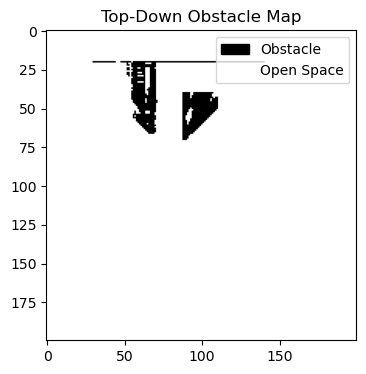

In [98]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(4, 5))
plt.imshow(topdown_map, cmap='gray')
plt.title("Top-Down Obstacle Map")


# Create proxy patches for the legend:
obstacle_patch = mpatches.Patch(color='black', label='Obstacle')
openspace_patch = mpatches.Patch(color='white', label='Open Space')

plt.legend(handles=[obstacle_patch, openspace_patch], loc='upper right')
plt.show()


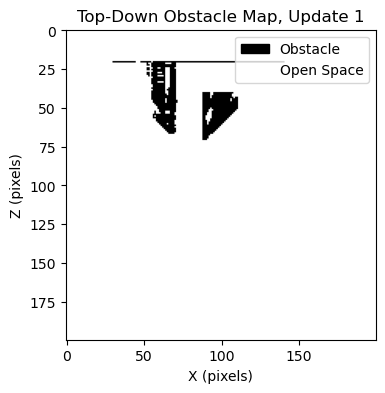

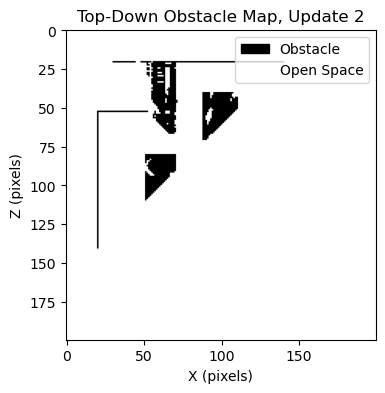

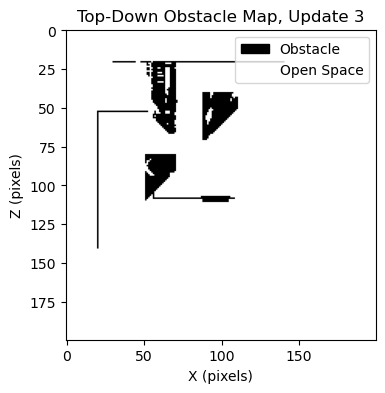

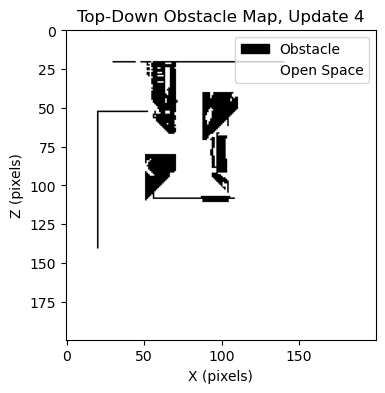

In [100]:
# =============================================================================
# MAIN: Sequential update loop.
# =============================================================================
def main_sequential(controller, num_updates=5, pause_time=1.0):
    """
    Sequentially updates the obstacle map as new RGB-D images are received.
    
    Args:
        controller: Simulation controller.
        num_updates: Number of sequential updates.
        pause_time: Time (in seconds) to wait between updates.
    """
    map_size = 200  # Example map size in pixels.
    pixels_per_meter = 20
    # Initialize persistent map: open space is white (255)
    persistent_map = np.ones((map_size, map_size), dtype=np.uint8) * 255
    
    for i in range(num_updates):
        # Assume the controller's last_event is updated externally.
        persistent_map = update_obstacle_map(controller, persistent_map,
                                             map_size=map_size, pixels_per_meter=pixels_per_meter,
                                             min_height=-0.1, max_height=1.8)
        # Display updated map inline.
        plt.figure(figsize=(4, 5))
        plt.imshow(persistent_map, cmap='gray', origin='upper')
        plt.title(f"Top-Down Obstacle Map, Update {i+1}")
        plt.xlabel("X (pixels)")
        plt.ylabel("Z (pixels)")
        # Create proxy patches for legend.
        obstacle_patch = mpatches.Patch(color='black', label='Obstacle')
        openspace_patch = mpatches.Patch(color='white', label='Open Space')
        plt.legend(handles=[obstacle_patch, openspace_patch], loc='upper right')
        plt.show()
        
        # Optional: Pause between updates.
        time.sleep(pause_time)
        controller.step(
            "RotateLeft",
        )

if __name__ == "__main__":
    # 'controller' must be defined and updated by your simulation environment.
    # For example, if using Habitat-Sim or iTHOR, controller.last_event is updated each frame.
    # Here we assume 'controller' is already defined.
    main_sequential(controller, num_updates=4, pause_time=1.0)

In [37]:
print(f"Points: {pts}")

Points: [[-9.1809e-07 -9.1809e-07  9.1809e-07]
 [-9.1174e-07 -9.1785e-07  9.1785e-07]
 [-9.0539e-07 -9.1762e-07  9.1762e-07]
 ...
 [ 6.6436e-07   6.734e-07  6.7792e-07]
 [ 6.6888e-07   6.734e-07  6.7792e-07]
 [  6.734e-07   6.734e-07  6.7792e-07]]


#### Point cloud to heading

In [ ]:
# Assume pts is an (N, 3) array from your point cloud,
# and that a lower y value corresponds to points from the lower half of the image.
# Choose an appropriate threshold for y. For instance, you might use the median value.
pts_lower = pts[pts[:, 1] > np.median(pts[:, 1])]


# Compute polar coordinates (r, theta) for each point in the horizontal plane.
# Assuming pts[:,0] is x (horizontal) and pts[:,2] is depth (forward).
angles = np.arctan2(pts_lower[:, 0], pts_lower[:, 2])  # 300x300 values in radians

# Compute horizontal distances using the x and z coordinates.
distances = np.linalg.norm(pts_lower[:, [0, 2]], axis=1)

# Create a histogram of angles (simulate a 1D laser scan)
# Dividing the scene into 90 bins
# Weights are inversely proportional to the distance, so closer obstacles contribute more.
num_bins = 90
hist, bin_edges = np.histogram(angles, bins=num_bins, weights=1/(distances + 1e-6))

# Find the bin with the smallest weighted obstacle presence
gap_index = np.argmin(hist)
gap_angle = (bin_edges[gap_index] + bin_edges[gap_index + 1]) / 2  # Middle angle of the bin

# Ensure goal_direction is defined. For example, assume straight ahead:
goal_direction = np.deg2rad(30)


# Blend the gap direction with the goal direction (tuning parameter)
alpha = 0.5
steering_angle = alpha * goal_direction + (1 - alpha) * gap_angle

print(f"Steering Angle (radians): {steering_angle:.2f}")
print(f"Steering Angle: {np.rad2deg(steering_angle):.2f} degrees")

Steering Angle (radians): 0.21
Steering Angle: 12.21 degrees


In [49]:
# Create a new point cloud for the filtered lower half points
pcd_lower = o3d.geometry.PointCloud()
pcd_lower.points = o3d.utility.Vector3dVector(pts_lower)

# Optional: color the points to distinguish them
pcd_lower.paint_uniform_color([1, 0, 0])  # colors the points red

# Visualize the filtered point cloud
o3d.visualization.draw_geometries([pcd_lower])

#### Point-cloud to Occupancy grid

In [ ]:
%pip install scikit-image
%pip install shapely

In [15]:
def get_objects_centers(objects, target_names):
    """
    Filters a list of objects for those whose name contains any of the target names
    and extracts their center x and y coordinates as a NumPy array.
    
    The center is taken from the object's 'axisAlignedBoundingBox' field if available,
    otherwise from the object's 'position'.
    
    Parameters:
        objects (list): A list of dictionaries representing scene objects.
        target_names (list): A list of strings representing substrings to match in the object name.
                             For example: ["Apple", "Bread"]
        
    Returns:
        np.ndarray: A tensor of shape (n, 2) where each row contains the [x, y]
                    coordinates of a matching object.
    """
    centers = []
    
    for obj in objects:
        name = obj.get("name", "")
        # Check if any of the target substrings is in the object's name
        if any(target in name for target in target_names):
            # Prefer the center from axisAlignedBoundingBox if available; otherwise, use the object's position.
            center = obj.get("axisAlignedBoundingBox", {}).get("center", obj.get("position"))
            
            if center is not None and "x" in center and "y" in center and "z" in center:
                centers.append([center["x"], center["y"], center["z"]])
            else:
                print(f"Center coordinates not available for object: {name}")
                
    return np.array(centers)


min x: -2.500056743621826, min z: -2.9326725006103516, max x: 2.474299907684326, max z: 2.5621533393859863


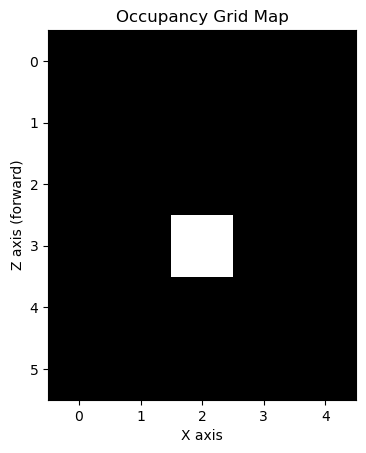

In [24]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from skimage.draw import line
from shapely.geometry import Polygon

# Assume these are obtained from the simulation
scene_bounds = controller.last_event.metadata["sceneBounds"]
corner_points = scene_bounds['cornerPoints']
unique_xz_points = [(p[0], p[2]) for p in corner_points]
scene_polygon = Polygon(unique_xz_points)
min_x, min_z, max_x, max_z = scene_polygon.bounds
print(f"min x: {min_x}, min z: {min_z}, max x: {max_x}, max z: {max_z}")

# Parameters for occupancy grid
GRID_RESOLUTION = 1  # meters per grid cell
GRID_WIDTH = int(np.ceil((max_x - min_x) / GRID_RESOLUTION))
GRID_HEIGHT = int(np.ceil((max_z - min_z) / GRID_RESOLUTION))
occupancy_grid = np.zeros((GRID_HEIGHT, GRID_WIDTH), dtype=np.uint8)

# Convert points to grid indices
for pt in pts:
    x, z = pt[0], pt[2]
    
    grid_x = int(np.clip((x - min_x) / GRID_RESOLUTION, 0, GRID_WIDTH - 1))
    grid_z = int(np.clip((z - min_z) / GRID_RESOLUTION, 0, GRID_HEIGHT - 1))

    occupancy_grid[GRID_HEIGHT - 1 - grid_z, grid_x] = 1  # Mark cell as occupied

# Visualize occupancy grid
plt.imshow(occupancy_grid, cmap='gray')
plt.title("Occupancy Grid Map")
plt.xlabel("X axis")
plt.ylabel("Z axis (forward)")
plt.show()


In [ ]:

# Example A* path planning (assuming start and goal positions)
import networkx as nx

def grid_to_graph(grid):
    G = nx.grid_2d_graph(*grid.shape)
    occupied = np.argwhere(grid == 1)
    for cell in occupied:
        G.remove_node(tuple(cell))
    return G

# Example source and goal (grid indices)
sx, sz = controller.last_event.metadata["agent"]["position"]["x"], controller.last_event.metadata["agent"]["position"]["z"]
source = (sx, sz)
target_items = ["HousePlant"]
objects = controller.last_event.metadata["objects"]
sourcePos = get_objects_centers(objects, target_items)
target = sourcePos[0]  
target_x, target_y, target_z = target
goal = (target_x, target_z)

# Create graph and plan path
G = grid_to_graph(occupancy_grid)

try:
    path = nx.astar_path(G, source, goal, heuristic=lambda a, b: np.linalg.norm(np.array(a)-np.array(b)))
    print("Path found:", path)
except nx.NetworkXNoPath:
    print("No path found")

# Visualize the path
for p in path:
    occupancy_grid[p] = 2

plt.imshow(occupancy_grid, cmap='gray')
plt.title('Occupancy Grid with Path')
plt.show()

#### Approach 2

In [ ]:
import open3d as o3d
import numpy as np
import math

def get_rgb_and_depth_from_event(controller):
    """
    Retrieves RGB and depth images from the iTHOR controller's last event.
    Assumes:
      - controller.last_event.depth_frame is a NumPy array.
      - controller.last_event.frame is an image (or array) for the RGB frame.
    """
    # Retrieve and process the depth image:
    depth_img = np.array(controller.last_event.depth_frame)
    depth_img = np.clip(depth_img, 0, 3.3)  # Clip depth values to 3.3 meters
    depth_scale = 1000.0  # Depth scale: convert to meters

    # Determine image dimensions
    height, width = depth_img.shape
    # Define camera intrinsic parameters (adjust focal lengths if needed)
    fx, fy = 150, 150  # Focal lengths in pixels
    cx, cy = width / 2, height / 2
    intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

    # Create Open3D Image objects for color and depth
    color_image = o3d.geometry.Image(np.array(controller.last_event.frame))
    depth_image = o3d.geometry.Image((depth_img / depth_scale).astype(np.float32))
    
    # Create RGBD image (do not convert RGB to intensity)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color=color_image,
        depth=depth_image,
        depth_trunc=3.3,  # Maximum depth to consider (in meters)
        convert_rgb_to_intensity=False)
    
    return rgbd_image, intrinsic

def create_point_cloud_from_event(controller):
    """
    Creates an Open3D point cloud from the latest iTHOR event.
    """
    rgbd_image, intrinsic = get_rgb_and_depth_from_event(controller)
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsic)
    return pcd

def vector_angle(u, v):
    """Returns the angle (in radians) between two vectors."""
    u = np.array(u)
    v = np.array(v)
    return np.arccos(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)))

def get_floor_plane(pcd, dist_threshold=0.02, ransac_n=3, num_iterations=1000):
    """
    Detects the dominant floor plane in the point cloud using RANSAC.
    Returns:
        plane_model: [a, b, c, d] for the plane equation ax + by + cz + d = 0.
    Raises:
        RuntimeError: if there are not enough points.
    """
    if np.asarray(pcd.points).shape[0] < ransac_n:
        raise RuntimeError("Not enough points in the point cloud to perform plane segmentation.")
    plane_model, inliers = pcd.segment_plane(distance_threshold=dist_threshold,
                                               ransac_n=ransac_n,
                                               num_iterations=num_iterations)
    return plane_model

def align_point_cloud_to_floor(pcd):
    """
    Aligns the point cloud so that the detected floor is horizontal (z-axis aligned).
    If there are not enough points or the plane cannot be detected,
    it prints a warning and returns the original point cloud.
    """
    try:
        plane_model = get_floor_plane(pcd)
    except RuntimeError as e:
        print(f"Floor segmentation skipped: {e}")
        return pcd

    a, b, c, d = plane_model

    # Translate the point cloud so that the floor lies at z = 0.
    if c != 0:
        translation = np.array([0, 0, -d / c])
    else:
        translation = np.zeros(3)
    pcd.translate(translation)

    # Compute the rotation required to align the floor normal with the global z-axis.
    plane_normal = np.array([a, b, c])
    z_axis = np.array([0, 0, 1])
    rotation_angle = vector_angle(plane_normal, z_axis)
    
    # Compute rotation axis as the cross product between the floor normal and z-axis.
    rotation_axis = np.cross(plane_normal, z_axis)
    if np.linalg.norm(rotation_axis) < 1e-6:
        # Already aligned.
        return pcd
    rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)

    # Apply an optimization factor if desired (here set to 1.0 for direct alignment)
    optimization_factor = 1.0
    axis_angle = rotation_axis * rotation_angle * optimization_factor

    # Rotate the point cloud about the origin.
    R = pcd.get_rotation_matrix_from_axis_angle(axis_angle)
    pcd.rotate(R, center=(0, 0, 0))
    return pcd

def transform_point_cloud_to_global(pcd, controller):
    """
    Transforms the point cloud from the robot (local) coordinate system to global coordinates
    using the robot's position and yaw rotation from controller.last_event.metadata.
    
    The transformation includes:
      - Rotation about the global z-axis (yaw)
      - Translation by the robot's global position
    """
    # Retrieve robot's position and yaw rotation (assumed to be in degrees)
    pos = controller.last_event.metadata["agent"]["position"]
    yaw_deg = controller.last_event.metadata["agent"]["rotation"]["y"]
    yaw_rad = np.deg2rad(yaw_deg)

    # Build the rotation matrix for a yaw rotation about the z-axis.
    R_yaw = np.array([[np.cos(yaw_rad), -np.sin(yaw_rad), 0],
                      [np.sin(yaw_rad),  np.cos(yaw_rad), 0],
                      [0,               0,               1]])
    
    # Create the translation vector from the agent's position.
    translation = np.array([pos["x"], pos["y"], pos["z"]])
    
    # Construct the 4x4 transformation matrix.
    T = np.eye(4)
    T[:3, :3] = R_yaw
    T[:3, 3] = translation

    # Apply the transformation to the point cloud.
    pcd.transform(T)
    return pcd

def process_observation(controller):
    """
    Processes the current iTHOR event:
      - Creates a point cloud from the RGB-D data.
      - Optionally downsamples the point cloud.
      - Aligns the point cloud so that the floor is horizontal.
      - Transforms the point cloud into global coordinates using the robot's metadata.
      - Visualizes the result.
    Returns:
        The point cloud transformed into global coordinates.
    """
    pcd = create_point_cloud_from_event(controller)
    # Downsample the point cloud for efficiency (optional)
    pcd = pcd.voxel_down_sample(voxel_size=0.02)
    
    # Align the point cloud so the floor is horizontal.
    aligned_pcd = align_point_cloud_to_floor(pcd)
    
    # Transform the aligned point cloud to global coordinates.
    global_pcd = transform_point_cloud_to_global(aligned_pcd, controller)
    
    # Visualize the global point cloud.
    o3d.visualization.draw_geometries([global_pcd])
    return global_pcd

# Example usage:
if __name__ == "__main__":
    # Assume 'controller' is your iTHOR simulation controller with the latest event.
    global_pcd = process_observation(controller)


#### Approach 3

### Shortest path from reachable positions

In [25]:
import networkx as nx
import numpy as np


# Get object centers
def get_objects_centers(objects, target_names):
    """
    Filters a list of objects for those whose name contains any of the target names
    and extracts their center x and y coordinates as a NumPy array.
    
    The center is taken from the object's 'axisAlignedBoundingBox' field if available,
    otherwise from the object's 'position'.
    
    Parameters:
        objects (list): A list of dictionaries representing scene objects.
        target_names (list): A list of strings representing substrings to match in the object name.
                             For example: ["Apple", "Bread"]
        
    Returns:
        np.ndarray: A tensor of shape (n, 2) where each row contains the [x, y]
                    coordinates of a matching object.
    """
    centers = []
    
    for obj in objects:
        name = obj.get("name", "")
        # Check if any of the target substrings is in the object's name
        if any(target in name for target in target_names):
            # Prefer the center from axisAlignedBoundingBox if available; otherwise, use the object's position.
            center = obj.get("axisAlignedBoundingBox", {}).get("center", obj.get("position"))
            
            if center is not None and "x" in center and "y" in center and "z" in center:
                centers.append([center["x"], center["y"], center["z"]])
            else:
                print(f"Center coordinates not available for object: {name}")
                
    return np.array(centers)


def create_graph_from_positions(positions, threshold=0.3):
    """
    Creates an undirected graph from a list of position dictionaries.
    Each node corresponds to a position and an edge is added if the
    Euclidean distance between two positions is less than or equal to threshold.

    Args:
        positions (list): List of dicts with keys 'x', 'y', 'z'
        threshold (float): Maximum distance to consider two positions connected

    Returns:
        networkx.Graph: A graph where nodes have an attribute 'pos' containing (x, y, z)
    """
    G = nx.Graph()
    
    # Add nodes with position attributes.
    for i, pos in enumerate(positions):
        G.add_node(i, pos=(pos['x'], pos['y'], pos['z']))
    
    # Add edges between nodes if the distance is within the threshold.
    for i in range(len(positions)):
        p1 = np.array([positions[i]['x'], positions[i]['y'], positions[i]['z']])
        for j in range(i + 1, len(positions)):
            p2 = np.array([positions[j]['x'], positions[j]['y'], positions[j]['z']])
            dist = np.linalg.norm(p1 - p2)
            if dist <= threshold:
                # You can store the distance as a weight.
                G.add_edge(i, j, weight=dist)
    return G

def find_nearest_node(graph, position):
    """
    Finds the nearest node in the graph to a given 3D position.

    Args:
        graph (networkx.Graph): Graph with nodes having a 'pos' attribute (x, y, z).
        position (tuple, list, or dict): The (x, y, z) position to compare.

    Returns:
        tuple: (nearest_node, distance) where nearest_node is the node index and distance is the Euclidean distance.
    """
    # Convert position to a numpy array if it's a dict.
    if isinstance(position, dict):
        position = np.array([position['x'], position['y'], position['z']])
    else:
        position = np.array(position)
    
    min_dist = float('inf')
    nearest_node = None
    for node in graph.nodes():
        node_pos = np.array(graph.nodes[node]['pos'])
        dist = np.linalg.norm(node_pos - position)
        if dist < min_dist:
            min_dist = dist
            nearest_node = node
    return nearest_node, min_dist

target_items = ["HousePlant"]

objects = controller.last_event.metadata["objects"]

source_pos = controller.last_event.metadata["agent"]["position"]
target_pos = get_objects_centers(objects, ["HousePlant"])[0]

positions = controller.step(action="GetReachablePositions").metadata["actionReturn"]

graph = create_graph_from_positions(positions, threshold=0.3)

source_node, src_dist = find_nearest_node(graph, source_pos)
target_node, tgt_dist = find_nearest_node(graph, target_pos)

try:
    path_nodes = nx.dijkstra_path(graph, source=source_node, target=target_node, weight='weight')
    print("Shortest path (node indices):", path_nodes)
    path_positions = [graph.nodes[node]['pos'] for node in path_nodes]
    print("Path positions:", path_positions)
except nx.NetworkXNoPath:
    print("No path exists between the given source and target positions.")


Shortest path (node indices): [0, 2, 7, 13, 20, 28, 35, 41, 48, 55, 61, 69, 79]
Path positions: [(-1.0, 0.900999128818512, 1.0), (-1.25, 0.900999128818512, 1.0), (-1.25, 0.900999128818512, 0.75), (-1.25, 0.900999128818512, 0.5), (-1.25, 0.900999128818512, 0.25), (-1.25, 0.900999128818512, 0.0), (-1.25, 0.900999128818512, -0.25), (-1.25, 0.900999128818512, -0.5), (-1.25, 0.900999128818512, -0.75), (-1.25, 0.900999128818512, -1.0), (-1.25, 0.900999128818512, -1.25), (-1.25, 0.900999128818512, -1.5), (-1.25, 0.900999128818512, -1.75)]


In [26]:
import networkx as nx
import numpy as np

# Assuming controller is already defined and connected to AI2Thor.

# Compute shortest path positions from previous steps
path_positions = [graph.nodes[node]['pos'] for node in path_nodes]

# Sequentially teleport along the calculated path
for pos in path_positions:
    controller.step(
        action="Teleport",
        position=dict(x=pos[0], y=pos[1], z=pos[2]),
        rotation=dict(x=0, y=controller.last_event.metadata['agent']['rotation']['y'], z=0)
    )
    print(f"Teleported to: x={pos[0]:.2f}, y={pos[1]:.2f}, z={pos[2]:.2f}")


Teleported to: x=-1.00, y=0.90, z=1.00
Teleported to: x=-1.25, y=0.90, z=1.00
Teleported to: x=-1.25, y=0.90, z=0.75
Teleported to: x=-1.25, y=0.90, z=0.50
Teleported to: x=-1.25, y=0.90, z=0.25
Teleported to: x=-1.25, y=0.90, z=0.00
Teleported to: x=-1.25, y=0.90, z=-0.25
Teleported to: x=-1.25, y=0.90, z=-0.50
Teleported to: x=-1.25, y=0.90, z=-0.75
Teleported to: x=-1.25, y=0.90, z=-1.00
Teleported to: x=-1.25, y=0.90, z=-1.25
Teleported to: x=-1.25, y=0.90, z=-1.50
Teleported to: x=-1.25, y=0.90, z=-1.75


In [2]:
import numpy as np

current_pos = np.array([-1.25, 0.90, -1.50])
next_pos = np.array([-1.25, 0.90, -1.75])

dir_vector = next_pos - current_pos
target_yaw_rad = np.arctan2(dir_vector[0], dir_vector[2])
target_yaw_deg = np.degrees(target_yaw_rad) % 360

current_yaw_deg = 90  # Currently facing 180-degree
rotation_needed = (target_yaw_deg - current_yaw_deg + 540) % 360 - 180  # Normalize to [-180,180]

print(f"Target yaw: {target_yaw_deg:.2f} degrees")
print(f"Rotation needed: {rotation_needed:.2f} degrees")


Target yaw: 180.00 degrees
Rotation needed: 90.00 degrees


## Graph knowledge

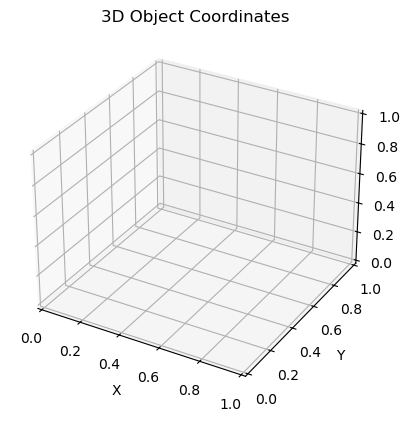

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import time

class Graph3DUpdater:
    def __init__(self):
        # Create an empty NetworkX graph
        self.graph = nx.Graph()
        
        # Set up the 3D plot
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111, projection='3d')
        
        # Set up plot labels and title
        self.ax.set_xlabel("X")
        self.ax.set_ylabel("Y")
        self.ax.set_zlabel("Z")
        self.ax.set_title("3D Object Coordinates")
        
        # Use interactive mode so updates show immediately.
        plt.ion()
        plt.show()

    def add_object(self, label, coord):
        """
        Adds a new object to the graph and updates the plot.
        
        Parameters:
            label: A unique identifier for the object (string).
            coord: A tuple or list of (x, y, z) coordinates.
        """
        # Add the new node with its coordinate as an attribute.
        self.graph.add_node(label, pos=coord)
        self._update_plot()
        
    def _update_plot(self):
        """Internal method to update the 3D plot from the current graph."""
        # Clear the current plot.
        self.ax.clear()
        
        # Reset labels and title
        self.ax.set_xlabel("X")
        self.ax.set_ylabel("Y")
        self.ax.set_zlabel("Z")
        self.ax.set_title("3D Object Coordinates")
        
        # Get positions from the graph
        positions = nx.get_node_attributes(self.graph, 'pos')
        
        # Plot each node and annotate it.
        for label, pos in positions.items():
            x, y, z = pos
            self.ax.scatter(x, y, z, s=100)
            self.ax.text(x, y, z, f' {label}', fontsize=10)
        
        # Redraw the figure
        plt.draw()
        plt.pause(0.001)  # Small pause to allow the plot to update

# --- Example usage ---
if __name__ == '__main__':
    updater = Graph3DUpdater()
    
    # Initially add some objects.
    updater.add_object("microwave", (-0.237, 1.689, -2.525))
    updater.add_object("oven", (-0.182, 2.112, -2.851))
    
    # Simulate a delay before a new object is learned.
    time.sleep(2)
    
    # Add a new object with its coordinates.
    updater.add_object("chair", (-0.300, 1.500, -2.700))
    
    # Keep the plot open.
    plt.ioff()
    plt.show()


# Plot data

## Robot trajectory

Scene Bounds (X-Z):
  X: -2.50 -> 2.47
  Z: -2.93 -> 2.56
Source Location: (np.float64(-0.23643067479133606), np.float64(-2.0105881690979004))


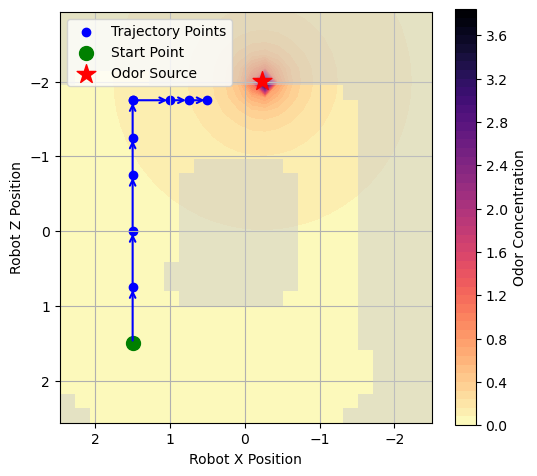

In [7]:

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon
from skimage.morphology import closing, disk

# -----------------------------
# 1. Compute the Plume Field
# -----------------------------

def get_objects_centers(objects, target_names):
    """
    Filters a list of objects for those whose name contains any of the target names
    and extracts their center x and y coordinates as a NumPy array.
    
    The center is taken from the object's 'axisAlignedBoundingBox' field if available,
    otherwise from the object's 'position'.
    
    Parameters:
        objects (list): A list of dictionaries representing scene objects.
        target_names (list): A list of strings representing substrings to match in the object name.
                             For example: ["Apple", "Bread"]
        
    Returns:
        np.ndarray: A tensor of shape (n, 2) where each row contains the [x, y]
                    coordinates of a matching object.
    """
    centers = []
    
    for obj in objects:
        name = obj.get("name", "")
        # Check if any of the target substrings is in the object's name
        if any(target in name for target in target_names):
            # Prefer the center from axisAlignedBoundingBox if available; otherwise, use the object's position.
            center = obj.get("axisAlignedBoundingBox", {}).get("center", obj.get("position"))
            
            if center is not None and "x" in center and "y" in center and "z" in center:
                centers.append([center["x"], center["y"], center["z"]])
            else:
                print(f"Center coordinates not available for object: {name}")
                
    return np.array(centers)

# -----------------------------
# Obtain Scene Bounds
# -----------------------------
scene_bounds = controller.last_event.metadata["sceneBounds"]
corner_points = scene_bounds['cornerPoints']  # each point is [x, y, z]
unique_xz_points = [(p[0], p[2]) for p in corner_points]
scene_polygon = Polygon(unique_xz_points)
min_x, min_z, max_x, max_z = scene_polygon.bounds

print("Scene Bounds (X-Z):")
print(f"  X: {min_x:.2f} -> {max_x:.2f}")
print(f"  Z: {min_z:.2f} -> {max_z:.2f}")

# -----------------------------
# 2. Define Grid & Compute Plume Field
# -----------------------------
grid_steps = 30  # Adjust resolution as needed
# Define the grid over scene bounds
X = np.linspace(min_x, max_x, grid_steps)
Y = np.linspace(min_z, max_z, grid_steps)
X_grid, Y_grid = np.meshgrid(X, Y)  # Create grid for contour plotting

objects = controller.last_event.metadata["objects"]
# odor_items = ["GarbageCan"]  # example
odor_items = ["Microwave"]  # example

odor_sources = get_objects_centers(objects, odor_items)
odor_x, odor_y, odor_z = odor_sources[0]

if odor_items == ["Microwave"]:
    odor_z += 0.5
elif odor_items == ["GarbageCan"]:
    odor_x += 0.25
    
print(f"Source Location: {odor_x, odor_z}")
# Compute the plume field
# Parameters
q_s = 2000  # Emission rate
D = 1000     # Diffusivity
U = 0       # Wind speed
tau = 1000  # Particle lifetime
del_t = 1   # Time step
psi = 320 * (math.pi / 180)  # Wind direction in radians

# Compute lambda
lambd = math.sqrt((D * tau) / (1 + (tau * U**2) / (4 * D)))

# Initialize field map
base_map = np.zeros((grid_steps, grid_steps))

rmin = 100

# Compute odor concentration values over the grid
# We'll iterate over index rather than directly over the coordinate arrays
for j in range(grid_steps):
    for i in range(grid_steps):
        x = X[i]
        y = Y[j]
        
        del_y = -(x - odor_x) * math.sin(psi) + (y - odor_z) * math.cos(psi)
        r = math.dist([x, y], [odor_x, odor_z])  # Euclidean distance
        
        if r < rmin: rmin=r

        try:
            m = (q_s / (4 * math.pi * D * r)) * math.exp((-del_y * U) / (2 * D) + (-r / lambd) * del_t)
        except ZeroDivisionError:
            # If r=0 or extremely small
            m = 0
        
        base_map[i, j] = m  # Store value in the matrix

# -----------------------------
# 3. Plot the Robot Trajectory
# -----------------------------

path = "Agent/save/SampleRuns_20-2-25/OO/Microwave/InitialPos 1.5,1.5/trajectory_log.csv"
# path = "Agent/save/SampleRuns_20-2-25/OO/Microwave/InitialPos 2,0/trajectory_log.csv"
# path = "Agent/save/SampleRuns_20-2-25/OO/Microwave/InitialPos -1.0,2.0/trajectory_log.csv"
# path = "Agent/save/SampleRuns_20-2-25/VO/Garbage/InitialPos 1.5,2/trajectory_log.csv"
# path = "Agent/save/SampleRuns_20-2-25/RW/Garbage/InitialPos 2,-1.5/trajectory_log.csv"
# path = "Agent/save/SampleRuns_20-2-25/RW/Garbage/InitialPos -1,-1.5/trajectory_log.csv"
df = pd.read_csv(path)

reachable = controller.step(action="GetReachablePositions").metadata["actionReturn"]
reach_x = np.array([pos["x"] for pos in reachable])
reach_z = np.array([pos["z"] for pos in reachable])

# Create a grid for reachable areas
resolution = 0.2
x_grid = np.arange(min_x, max_x, resolution)
z_grid = np.arange(min_z, max_z, resolution)
X, Z = np.meshgrid(x_grid, z_grid)

# Build a binary mask for reachable areas
mask = np.zeros(X.shape, dtype=bool)
threshold = resolution * 1.5

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        dists = np.sqrt((reach_x - X[i, j])**2 + (reach_z - Z[i, j])**2)
        if np.any(dists < threshold):
            mask[i, j] = True

# Smooth the mask
mask_closed = closing(mask, disk(1))
alpha_mask = (~mask_closed).astype(float)

# -----------------------------
# 4. Combine the Layers, Using a Contour Map for the Plume
# -----------------------------
plt.figure(figsize=(6, 6))

# (A) Plot the odor field as a contour map (instead of imshow)
contour = plt.contourf(X_grid, Y_grid, base_map.T, levels=60, cmap='magma_r', zorder=1)
plt.colorbar(contour, label='Odor Concentration', shrink=0.9)

# (B) Overlay the grey mask for non-reachable areas
grey = np.array([0.8, 0.8, 0.8, 1.0])
overlay = np.tile(grey, mask.shape + (1,))
overlay[..., 3] = alpha_mask
plt.imshow(overlay, extent=[min_x, max_x, min_z, max_z], origin="lower", zorder=2, alpha=0.5)

# # (C) Plot the robot trajectory
plt.scatter(df['robot x'], df['robot z'], color='blue', marker='o', label="Trajectory Points")
for i in range(1, len(df)):
    x_start = df['robot x'].iloc[i-1]
    z_start = df['robot z'].iloc[i-1]
    x_end = df['robot x'].iloc[i]
    z_end = df['robot z'].iloc[i]
    plt.annotate("",
                 xy=(x_end, z_end), xycoords='data',
                 xytext=(x_start, z_start), textcoords='data',
                 arrowprops=dict(arrowstyle="->", color='blue', lw=1.5))

# Mark the starting point
if not df.empty:
    start_x = df['robot x'].iloc[0]
    start_z = df['robot z'].iloc[0]
    plt.scatter(start_x, start_z, color='green', marker='o', s=100, label="Start Point")

# (D) Plot the odor source on the map

plt.scatter(odor_x, odor_z, color='red', marker='*', s=200, label="Odor Source", zorder=3)

# Labeling and axis formatting
plt.xlabel('Robot X Position')
plt.ylabel('Robot Z Position')

plt.xlim(min_x, max_x)
plt.ylim(max_z, min_z)  # Invert Z-axis if desired
plt.gca().invert_xaxis()  # Invert X-axis so negative X is to the right
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.legend()
plt.show()


## Table

In [40]:
import pandas as pd
import numpy as np

def calculate_total_distance(csv_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Ensure the columns exist
    if not {'robot x', 'robot z'}.issubset(df.columns):
        raise ValueError("CSV file must contain 'robot x' and 'robot z' columns")
    
    # Compute the Euclidean distance between consecutive points
    df['distance'] = np.sqrt((df['robot x'].diff())**2 + (df['robot z'].diff())**2)
    
    # Sum up the distances
    total_distance = df['distance'].sum()
    
    return total_distance


# Example usage
if __name__ == "__main__":
    # csv_file = "Agent/save/SampleRuns_20-2-25/RW/Microwave/InitialPos 1.5,1.5/trajectory_log.csv"  # Change this to your actual file name
    # csv_file = "Agent/save/SampleRuns_20-2-25/RW/Microwave/InitialPos 2,0/trajectory_log.csv"  # Change this to your actual file name
    # csv_file = "Agent/save/SampleRuns_20-2-25/RW/Microwave/InitialPos -1.0,2.0/trajectory_log.csv"  # Change this to your actual file name

    # csv_file = "Agent/save/SampleRuns_20-2-25/RW/Garbage/InitialPos 1.5,2/trajectory_log.csv"  # Change this to your actual file name
    # csv_file = "Agent/save/SampleRuns_20-2-25/RW/Garbage/InitialPos 2,-1.5/trajectory_log.csv"  # Change this to your actual file name
    csv_file = "Agent/save/SampleRuns_20-2-25/RW/Garbage/InitialPos -1,-1.5/trajectory_log.csv"  # Change this to your actual file name
    
    total_distance = calculate_total_distance(csv_file)
    print(f"Total distance traveled: {total_distance:.2f} units")


Total distance traveled: 25.00 units
